<a href="https://colab.research.google.com/github/sajtarius/practice/blob/main/correction_causality_gc_te_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.2/551.2 kB 7.0 MB/s eta 0:00:00


In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
package_path = "/content/packages"
os.symlink('/content/drive/My Drive/Packages', package_path)
sys.path.insert(0, package_path)

MessageError: ignored

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 
import pickle
from plotly.subplots import make_subplots
from matplotlib.animation import FuncAnimation 
from tqdm import tqdm 
from scipy.fft import fft, ifft, fftfreq, fftshift 
from scipy import signal
from scipy import stats
from scipy.integrate import trapezoid, cumtrapz, solve_ivp
from KDEpy import FFTKDE
#%matplotlib notebook

In [ ]:
from pyunicorn.timeseries.surrogates import Surrogates

# All the functions

## Granger causality --> Wilson Algorithm

In [ ]:
###functions for all calculation###
##############################################################
###spectrum of two signals###
def spec(s1, s2, time):
    fs1 = fft(s1) #fourier transform signal 1
    fs2 = fft(s2) #fourier transform signal 2
    freq_fs = fftfreq(len(time), d=(time[1] - time[0])) #frequency of the signals
    fs2_con = np.conj(fs2) #conjugate the signal 2
    spectrum = np.mean(fs1*fs2_con, axis=0)/len(time) #element of the spectrum --> [auto] when [s1 = s2]; [cross] when [s1 != s2]
    return spectrum, freq_fs

###[wilson algorithm] is used for factorizing the [spectral matrix] to [transfer matrix] and [covariance matrix of noise]###
#plus operator
def plus(g):
    m = g.shape[0]
    nw = g.shape[2]
    beta = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            beta[i,j,:] = ifft(g[i,j,:])
    betap = beta.copy()
    beta0 = 0.5*beta[:,:,0]
    betap[:,:,0] = np.triu(beta0) 
    betap[:,:,int(nw/2):] = 0 
    gp = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            gp[i,j,:] = fft(betap[i,j,:]) 
    return gp 

#wilson algorithm
def wilson(s, freq, ite, tol): #spectrum, frequency, iteration_number, accepted error
    m = s.shape[0] 
    nw = s.shape[2] 
    R = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            R[i,j,:] = ifft(s[i,j,:])
    psi = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        psi[:,:,i] = np.linalg.cholesky(R[:,:,0])
    g = np.zeros((m,m,nw))*(1+1j)
    I = np.eye(m,m)
    for t in range(0, ite, 1):
        for i in range(0, nw, 1):
            g[:,:,i] = np.linalg.inv(psi[:,:,i]) @ s[:,:,i] @ np.conj(np.linalg.inv(psi[:,:,i]).T)
            g[:,:,i] = g[:,:,i] + I 
        gp = plus(g)
        psi_old = psi.copy()
        psi_err = 0 
        for i in range(0, nw, 1):
            psi[:,:,i] = psi[:,:,i] @ gp[:,:,i]
            psi_err = psi_err + np.linalg.norm(psi[:,:,i] - psi_old[:,:,i])/nw
        if psi_err < tol: 
            break 
    A = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            A[i,j,:] = ifft(psi[i,j,:])
    A0 = A[:,:,0]
    cov = A0 @ A0.T
    H = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        H[:,:,i] = psi[:,:,i] @ np.linalg.inv(A0)
    freq_new = freq[int(len(freq)/2):] #included so that the frequency information is retained. 
    return H, cov, freq



## Transfer Entropy

In [ ]:
##############################################################
###[transfer entropy] for one signal###
def cal_transfer(source, target, size, alpha):
    new_target = target[alpha+1:]
    old_target = target[:-1-alpha]
    old_source = source[:-1-alpha]
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size))
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size)
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size))
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size))
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 

###[transfer entropy] for all the simulation###
def all_cal_transfer(source, target, size, alpha, sim):
    new_target = target[:,alpha+1:].reshape((target[0,alpha+1:].shape[0]*sim))
    old_target = target[:,:-1-alpha].reshape((target[0,:-1-alpha].shape[0]*sim))
    old_source = source[:,:-1-alpha].reshape((source[0,:-1-alpha].shape[0]*sim))
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size), 
                                        range=[[np.min(target), np.max(target)], [np.min(target), np.max(target)], [np.min(source), np.max(source)]])
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size, range=[[np.min(target), np.max(target)]])
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size), range=[[np.min(target), np.max(target)], [np.min(source), np.max(source)]])
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size), range=[[np.min(target), np.max(target)], [np.min(target), np.max(target)]])
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 



## KL Divergence

In [ ]:
##############################################################
###[KL divergence] calculation for 1-dimensional [pdf]###
def kl(pdf, axis, time):
    sol = []

    for i in range(0, len(time)-1, 1):
        difaxs = axis[i][0][1] - axis[i][0][0]
        divlog = np.log2(pdf[i+1]/pdf[i])
        divlog = np.nan_to_num(divlog, nan=0.0, neginf=0.0, posinf=0.0)

        sol.append(np.sum(pdf[i+1] * divlog * difaxs)) #KL divergence calculation. NOTE: the estimated distributions are PDF!!!

    sol = np.array(sol)
    newt = np.delete(time, 0)

    return sol, newt

###[KL divergence] calculation for 2-dimensional [pdf]###
def kl2D(pdf, axis, time):
    sol = []

    for i in range(0, len(time)-1, 1):
        difx1 = axis[i][0][1] - axis[i][0][0]
        difx2 = axis[i][1][1] - axis[i][1][0]
        temp_div = np.einsum('ij,ij->ij', pdf[i+1][:][:], 1/(pdf[i][:][:])) 
        temp_log = np.log2(temp_div) 
        temp_log = np.nan_to_num(temp_log, nan=0.0, neginf=0.0, posinf=0.0) 
        temp_sol = np.einsum('ij,ij', pdf[i+1][:][:], temp_log) 
    
        sol.append(temp_sol * difx1 * difx2)

    sol = np.array(sol)
    newt = np.delete(time, 0)

    return sol, newt

###evoltion of [KL divergence]###
def kl_evol(signal1, signal2, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3)))
    size = int(np.sqrt(size))

    datatime = []
    kl1to2 = []
    kl2to1 = []
    kl1 = []
    kl2 = []

    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        timenew = time[t:t+win]

        pdf1sld = []
        axs1sld = []

        pdf2sld = []
        axs2sld = []

        pdf1 = []
        axs1 = []
        
        pdf2 = []
        axs2 = []

        newtime = []

        for i in range(sld):
            H1sld, edges1sld = np.histogramdd(np.array([signal1new[:,i:i+sld].reshape(sld*sim), signal2new[:,0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H2sld, edges2sld = np.histogramdd(np.array([signal1new[:,0:sld].reshape(sld*sim), signal2new[:,i:i+sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H1, edges1 = np.histogramdd(signal1new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal1), np.max(signal1)]])
            H2, edges2 = np.histogramdd(signal2new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal2), np.max(signal2)]])
            
            pdf1sld.append(H1sld)
            axs1sld.append(edges1sld)
            
            pdf2sld.append(H2sld)
            axs2sld.append(edges2sld)
            
            pdf1.append(H1)
            axs1.append(edges1)
            
            pdf2.append(H2)
            axs2.append(edges2)
            
            newtime.append(timenew[i])

        temp_kl1sld, temp_time1sld = kl2D(pdf1sld, axs1sld, newtime)
        temp_kl2sld, temp_time2sld = kl2D(pdf2sld, axs2sld, newtime)
        temp_kl1, temp_time1 = kl(pdf1, axs1, newtime)
        temp_kl2, temp_time2 = kl(pdf2, axs2, newtime)

        kl1to2.append(temp_kl2sld)
        kl2to1.append(temp_kl1sld)
        kl1.append(temp_kl1)
        kl2.append(temp_kl2)

        datatime.append(temp_time1sld)
    
    data = {'kl_1to2': kl1to2, 'kl_2to1': kl2to1, 'kl_1': kl1, 'kl_2': kl2}

    return data, datatime



## Evolution of the probability distribution (PDF)

In [ ]:
##############################################################
###evolution of [pdf] with the estimation of [pdf] via [histogram]###
def pdf_evol(signal1, signal2, time, window, slide, sim):
    pdfx1 = []
    axsx1 = []
    
    pdfx2 = []
    axsx2 = []
    
    pdfjoint = []
    axsjoint = []
    
    pdfmul = []
    axsmul = []
    
    newt = []
    
    win = window 
    sld = slide 
    
    size = int(np.ceil(2*(sim*win)**(1/3)))
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        Hx1, edgesx1 = np.histogramdd(signal1[:, t:t+win].reshape(win*sim).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)]])
        Hx2, edgesx2 = np.histogramdd(signal2[:, t:t+win].reshape(win*sim).T, density=True, bins=size, range=[[np.min(signal2), np.max(signal2)]])
        Hx1x2, edgesx1x2 = np.histogramdd(np.array([signal1[:, t:t+win].reshape(win*sim), signal2[:, t:t+win].reshape(win*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
        
        mulHx1x2 = np.einsum('i,j->ij', Hx1, Hx2)
        
        pdfx1.append(Hx1)
        axsx1.append(edgesx1)
        
        pdfx2.append(Hx2)
        axsx2.append(edgesx2)
        
        pdfjoint.append(Hx1x2)
        axsjoint.append(edgesx1x2)
        
        pdfmul.append(mulHx1x2)
        axsmul.append(edgesx1x2)
        
        newt.append(time[t])
        
    pdfx1 = np.array(pdfx1)
    axsx1 = np.array(axsx1)
    
    pdfx2 = np.array(pdfx2)
    axsx2 = np.array(axsx2)
    
    pdfjoint = np.array(pdfjoint)
    axsjoint = np.array(axsjoint)
    
    pdfmul = np.array(pdfmul)
    axsmul = np.array(axsmul)
    
    newt = np.array(newt)
    
    data = {'pdf_joint': [pdfjoint, axsjoint], 'pdf_mul': [pdfmul, axsmul], 'pdf_1': [pdfx1, axsx1], 'pdf_2': [pdfx2, axsx2]}
    
    return data, newt

###evolution of [conditional pdf] with estimation of [pdf] via [histogram]###
def pdf_evol_condi(signal1, signal2, time, window, slide, sim):
    win = window
    sld = slide 
    
    size = int(np.ceil(2*(sim*win)**(1/3)))
    size = int(np.sqrt(size))
    
    pdfcond1 = []
    axscond1 = []
    
    pdfcond2 = []
    axscond2 = []
    
    newt = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        Hjoint, edgesjoint = np.histogramdd(np.array([signal1[:, t:t+win].reshape(win*sim), signal2[:, t:t+win].reshape(win*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
        Hx1, edgesx1 = np.histogramdd(signal1[:, t:t+win].reshape(win*sim), density=True, bins=size, range=[[np.min(signal1), np.max(signal1)]])
        Hx2, edgesx2 = np.histogramdd(signal2[:, t:t+win].reshape(win*sim), density=True, bins=size, range=[[np.min(signal2), np.max(signal2)]])
        
        Hcondi1 = np.einsum('ij, i->ij', Hjoint, 1/Hx1) #conditional pdf p(x2|x1) = p(x1,x2)/p(x1)
        Hcondi1 = np.nan_to_num(Hcondi1, nan=0.0, neginf=0.0, posinf=0.0) 
        
        Hcondi2 = np.einsum('ij, j->ij', Hjoint, 1/Hx2) #conditional pdf p(x1|x2) = p(x1,x2)/p(x2)
        Hcondi2 = np.nan_to_num(Hcondi2, nan=0.0, neginf=0.0, posinf=0.0)
        
        pdfcond1.append(Hcondi1)
        axscond1.append(edgesjoint)
        
        pdfcond2.append(Hcondi2)
        axscond2.append(edgesjoint)
        
        newt.append(time[t])
        
    pdfcond1 = np.array(pdfcond1)
    axscond1 = np.array(axscond1)
    
    pdfcond2 = np.array(pdfcond2)
    axscond2 = np.array(axscond2)
    
    newt = np.array(newt)
    
    data = {'pdf_cond1': [pdfcond1, axscond1], 'pdf_cond2': [pdfcond2, axscond2]}
    
    return data, newt

###estimate the evolution of [pdf] with one of the signal used as the reference###
def pdf_evol_move(move, fix, time, window, slide, sim):
    win = window 
    sld = slide 
    size = int(np.ceil(2*(sim*win)**(1/3)))

    fixnew = fix[:,:].reshape(len(time)*sim) #whole [fix's signal] is used as the reference that is "causing" [move's signal]

    pdf_xm = []
    axs_xm = []

    newt = []

    for t in tqdm(range(0, len(time)-win+1, sld)):

        movenew = move[:,t:t+win].reshape(win*sim)

        ###making the [fix] and [move] to have same dimension for histogram estimation###
        if len(movenew) > len(fixnew):
            temp_len = len(movenew) - len(fixnew)
            temp_x = np.zeros(temp_len)
            temp_x.fill(np.nan)
            fixnew = np.concatenate((fixnew, temp_x))
        elif len(fixnew) > len(movenew):
            temp_len = len(fixnew) - len(movenew)
            temp_x = np.zeros(temp_len)
            temp_x.fill(np.nan)
            movenew = np.concatenate((movenew, temp_x))

        H, edges = np.histogramdd(np.array([movenew, fixnew]).T, density=True, bins=50, range=[[np.min(move), np.max(move)], [np.min(fix), np.max(fix)]])

        pdf_xm.append(H)
        axs_xm.append(edges)

        newt.append(time[t])

    pdf_xm = np.array(pdf_xm)
    axs_xm = np.array(axs_xm)
    newt = np.array(newt)

    data = {'pdf_move': [pdf_xm, axs_xm]}

    return data, newt

###estimate the evolution of [pdf] with one of the signal used as the reference [along with reference signal "expanding"]###
def pdf_evol_ref(evo, ref, time, window, slide, sim):
    win = window
    sld = slide 
    size = int(np.ceil(2*(sim*win)**(1/3)))

    newtime = []
    newpdf = []
    newaxs = []

    for tf in tqdm(range(0, len(time)-win+1, sld)):

        refnew = ref[:,0:tf+win].reshape((tf+win)*sim) #[ref's signal] will serve as reference from the "beginning of the window" to the "end of the window".

        pdf_xm = []
        axs_xm = []

        newt = []

        for t in range(tf, len(tdata)-win+1, sld):

            evonew = evo[:,t:t+win].reshape(win*sim)

            ###making the [ref] and [evo] to have same dimension for histogram estimation###
            if len(evonew) > len(refnew):
                temp_len = len(evonew) - len(refnew)
                temp_x = np.zeros(temp_len)
                temp_x.fill(np.nan)
                refnew = np.concatenate((refnew, temp_x))
            elif len(refnew) > len(evonew):
                temp_len = len(refnew) - len(evonew)
                temp_x = np.zeros(temp_len)
                temp_x.fill(np.nan)
                evonew = np.concatenate((evonew, temp_x))

            H, edges = np.histogramdd(np.array([evonew, refnew]).T, density=True, bins=50, range=[[np.min(evo), np.max(evo)], [np.min(ref), np.max(ref)]])

            pdf_xm.append(H)
            axs_xm.append(edges)

            newt.append(time[t])

        newpdf.append(pdf_xm)
        newaxs.append(axs_xm)
        newtime.append(newt)

    return newpdf, newaxs, newtime

###evolution of [pdf] with the estimation of [pdf] via [kernel density]###
def pdf_evol_kernel(signal1, signal2, time, window, slide, sim, point):
    win = window
    sld = slide
    pnt = point #number of point in the [pdf]
    
    pdf1 = []
    axis1 = []
    #x1 = np.linspace(-1*max_value, max_value, pnt) #"fix" the x-axis of the [pdf] for every time
    x1 = np.linspace(np.min(signal1)*1.5, np.max(signal1)*1.5, pnt) #'fix' the axis based on the 1.5 times of max and min values
    
    pdf2 = []
    axis2 = []
    #x2 = np.linspace(-1*max_value, max_value, pnt) #"fix" the x-axis of the [pdf] for every time
    x2 = np.linspace(np.min(signal2)*1.5, np.max(signal2)*1.5, pnt) #'fix' the axis based on the 1.5 times of max and min values

    pdf12_joint = []
    axis12_joint = []

    pdf12_mul = []
    axis12_mul = []
    
    newt = []
    
    axs1, axs2 = np.mgrid[np.min(signal1)*1.5:np.max(signal1)*1.5:pnt*1j, np.min(signal2)*1.5:np.max(signal2)*1.5:pnt*1j]
    grid = np.c_[axs1.ravel(), axs2.ravel()]

    for t in tqdm(range(0, len(time)-win+1, sld)):
        y1 = FFTKDE(kernel='gaussian', bw='ISJ').fit(signal1[:, t:t+win].reshape(win*sim)).evaluate(x1)
        y2 = FFTKDE(kernel='gaussian', bw='ISJ').fit(signal2[:, t:t+win].reshape(win*sim)).evaluate(x2)
        y12_joint = FFTKDE(kernel='gaussian').fit(np.vstack([signal1[:, t:t+win].reshape(win*sim),
                                                             signal2[:, t:t+win].reshape(win*sim)]).T).evaluate(grid).reshape(axs1.shape)
        
        y12_mul = np.einsum('i,j->ij', y1, y2)

        pdf1.append(y1)
        axis1.append(x1)
        
        pdf2.append(y2)
        axis2.append(x2)

        pdf12_joint.append(y12_joint)
        axis12_joint.append([axs1, axs2])

        pdf12_mul.append(y12_mul)
        axis12_mul.append([axs1, axs2])

        newt.append(time[t])
        
    pdf1 = np.array(pdf1)
    pdf2 = np.array(pdf2)
    
    axis1 = np.array(axis1)
    axis2 = np.array(axis2)

    pdf12_joint = np.array(pdf12_joint)
    axis12_joint = np.array(axis12_joint)

    pdf12_mul = np.array(pdf12_mul)
    axis12_mul = np.array(axis12_mul)
    
    newt = np.array(newt)
    
    data = {'pdf_1': [pdf1, axis1], 'pdf_2': [pdf2, axis2], 'pdf_joint': [pdf12_joint, axis12_joint], 'pdf_mul': [pdf12_mul, axis12_mul]}
    
    return data, newt

## Information rate calculation

In [ ]:
##############################################################
###[information rate square] for 1D [pdf]###
def info_rate(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage.
    
    for i in range(0, len(time)-1, 1):
        difx = axis[i][0][1] - axis[i][0][0] #[delta x] for integration usage.
        sqrt1 = np.sqrt(pdf[i])
        sqrt2 = np.sqrt(pdf[i+1])
        temp = (sqrt2 - sqrt1)**2
        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation. 
        
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for 2D [pdf]###
def info_rate2D(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage. 
    
    for i in range(0, len(time)-1, 1):
        difx2 = axis[i][1][1] - axis[i][1][0] #[delta x2] for integration usage. 
        difx1 = axis[i][0][1] - axis[i][0][0] #[delta x1] for integration usage. 
        sqrt1 = np.sqrt(pdf[i][:][:])
        sqrt2 = np.sqrt(pdf[i+1][:][:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx2 * difx1 / dift**2)) #[information rate square] calculation. 
    
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for [kernel estimated pdf]###
def info_rate_kernel(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for the integration usage. 

    for i in range(0, len(time)-1, 1):
        difx = axis[i][1] - axis[i][0] #[delta x] for the integration usage. 
        sqrt1 = np.sqrt(pdf[i])
        sqrt2 = np.sqrt(pdf[i+1])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation 
    
    rate2 = np.array(rate2) 
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for 2D [kernel estimated pdf]###
def info_rate2D_kernel(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage. 
    
    for i in range(0, len(time)-1, 1):
        difx1 = axis[i][0].T[0][1] - axis[i][0].T[0][0]
        difx2 = axis[i][1][0][1] - axis[i][1][0][0]
        sqrt1 = np.sqrt(pdf[i][:][:])
        sqrt2 = np.sqrt(pdf[i+1][:][:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx2 * difx1 / dift**2)) #[information rate square] calculation. 
    
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt



# Trying [information rate 3D]

In [ ]:
def info_rate3D(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage 

    for i in range(0, len(time)-1, 1): 
        difx1 = axis[i][0][1] - axis[i][0][0] 
        difx2 = axis[i][1][1] - axis[i][1][0]
        difx3 = axis[i][2][1] - axis[i][2][0]
        sqrt1 = np.sqrt(pdf[i][:][:][:])
        sqrt2 = np.sqrt(pdf[i+1][:][:][:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx1 * difx2 * difx3 / dift**2))

    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time

    return rate2, newt

## Information rate causality calculation

In [ ]:
###[information rate causality] by evaluating at [window of signals]; [one signal] will be fixed and the evolution is calculated for [another signal]. 
def info_rate_causal(signal1, signal2, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3)))
    size = int(np.sqrt(size))
    
    datatime = []
    rate1to2 = []
    rate2to1 = []
    rate1 = []
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        timenew = time[t:t+win]
        
        pdf1sld = [] #the change of [pdf] for [signal 1] given [signal 2]. 
        axs1sld = [] #the axes of the [pdf] for the [pdf1sld]
        
        pdf2sld = [] #the change of [pdf] for [signal 2] given [signal 1]. 
        axs2sld = [] #the axes of the [pdf] for the [pdf2sld]
        
        pdf1 = []
        axs1 = []
        
        pdf2 = []
        axs2 = []
        
        newtime = []
        
        for i in range(sld): #edited here!!!
            H1sld, edges1sld = np.histogramdd(np.array([signal1new[:,i:i+sld].reshape(sld*sim), signal2new[:,0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H2sld, edges2sld = np.histogramdd(np.array([signal1new[:,0:sld].reshape(sld*sim), signal2new[:,i:i+sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H1, edges1 = np.histogramdd(signal1new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal1), np.max(signal1)]])
            H2, edges2 = np.histogramdd(signal2new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal2), np.max(signal2)]])
            
            pdf1sld.append(H1sld)
            axs1sld.append(edges1sld)
            
            pdf2sld.append(H2sld)
            axs2sld.append(edges2sld)
            
            pdf1.append(H1)
            axs1.append(edges1)
            
            pdf2.append(H2)
            axs2.append(edges2)
            
            newtime.append(timenew[i])
            
        temp_mean1sld, temp_std1sld = mean_std_evol(pdf1sld, axs1sld, newtime)
        temp_mean2sld, temp_std2sld = mean_std_evol(pdf2sld, axs2sld, newtime)
        temp_mean1, temp_std1 = mean_std_evol(pdf1, axs1, newtime)
        temp_mean2, temp_std2 = mean_std_evol(pdf2, axs2, newtime)
            
        temp_rate1sld, temp_time1sld = info_rate2D(pdf1sld, axs1sld, newtime)
        temp_rate2sld, temp_time2sld = info_rate2D(pdf2sld, axs2sld, newtime)
        temp_rate1, temp_time1 = info_rate(pdf1, axs1, newtime)
        temp_rate2, temp_time2 = info_rate(pdf2, axs2, newtime)
        
        rate2to1.append(temp_rate1sld)
        rate1to2.append(temp_rate2sld)
        rate1.append(temp_rate1)
        rate2.append(temp_rate2)
        
        datatime.append(temp_time1sld)
        
    data = {'rate_1to2': rate1to2, 'rate_2to1': rate2to1, 'rate_1': rate1, 'rate_2': rate2}
    
    return data, datatime

###[information rate causality] by evaluating at [window of signals]; [one signal] will be fixed and the evolution is calculated for [another signal]. The PDF is estimated via [kernel density estimation].
def info_rate_causal_kernel(signal1, signal2, time, window, sim, point):
    win = window 
    sld = int(win/2)
    pnt = point
    factor = 1.15 #the number of time of the lowest and highest value to "accommodate" the [kernel estimation].
    
    datatime = []
    rate1to2 = []
    rate2to1 = []
    rate1 = []
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        timenew = time[t:t+win]
        
        x1 = np.linspace(np.min(signal1new)*factor, np.max(signal1new)*factor, pnt) #'fix' the axis based on the [factor] times of max and min values
        x2 = np.linspace(np.min(signal2new)*factor, np.max(signal2new)*factor, pnt) #'fix' the axis based on the [factor] times of max and min values
        
        axs1, axs2 = np.mgrid[np.min(signal1new)*factor:np.max(signal1new)*factor:pnt*1j, np.min(signal2new)*factor:np.max(signal2new)*factor:pnt*1j]
        grid = np.c_[axs1.ravel(), axs2.ravel()]

        pdf1sld = [] #the change of [pdf] for [signal 1] given [signal 2]. 
        axs1sld = [] #the axes of the [pdf] for the [pdf1sld]

        pdf2sld = [] #the change of [pdf] for [signal 2] given [signal 1]. 
        axs2sld = [] #the axes of the [pdf] for the [pdf2sld]

        pdf1 = []
        axis1 = []
        
        pdf2 = []
        axis2 = []
        
        newtime = []
        
        for i in range(0, sld, 1): #edited here!!!
            H1sld = FFTKDE(kernel='gaussian').fit(np.vstack([signal1new[:, i:i+sld].reshape(sld*sim), signal2new[:, 0:sld].reshape(sld*sim)]).T).evaluate(grid).reshape(axs1.shape)
            H2sld = FFTKDE(kernel='gaussian').fit(np.vstack([signal1new[:, 0:sld].reshape(sld*sim), signal2new[:, i:i+sld].reshape(sld*sim)]).T).evaluate(grid).reshape(axs1.shape)
            H1 = FFTKDE(kernel='gaussian', bw='ISJ').fit(signal1new[:, i:i+sld].reshape(sld*sim)).evaluate(x1)
            H2 = FFTKDE(kernel='gaussian', bw='ISJ').fit(signal2new[:, i:i+sld].reshape(sld*sim)).evaluate(x2)
            
            pdf1sld.append(H1sld)
            axs1sld.append([axs1, axs2])
            
            pdf2sld.append(H2sld)
            axs2sld.append([axs1, axs2])
            
            pdf1.append(H1)
            axis1.append(x1)
            
            pdf2.append(H2)
            axis2.append(x2)
            
            newtime.append(timenew[i])
            
        temp_rate1sld, temp_time1sld = info_rate2D_kernel(pdf1sld, axs1sld, newtime)
        temp_rate2sld, temp_time2sld = info_rate2D_kernel(pdf2sld, axs2sld, newtime)
        temp_rate1, temp_time1 = info_rate_kernel(pdf1, axis1, newtime)
        temp_rate2, temp_time2 = info_rate_kernel(pdf2, axis2, newtime)
        
        rate2to1.append(temp_rate1sld)
        rate1to2.append(temp_rate2sld)
        rate1.append(temp_rate1)
        rate2.append(temp_rate2)
        
        datatime.append(temp_time1sld)
        
    data = {'rate_1to2': rate1to2, 'rate_2to1': rate2to1, 'rate_1': rate1, 'rate_2': rate2}
    
    return data, datatime

###[information rate causality] by having the [initial pdf] as the "fixed pdf" for reference and compare with the [moving pdf]###
def info_rate_causalref(smove, snomove, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3))) #rice rule to determine the size of the bins used for histogram estimation 
    size = int(np.sqrt(size))
    print('bin size (Rice rule):', size)
    
    datatime = []
    
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        smovenew = smove[:, t:t+win]
        snomovenew = snomove[:, t:t+win]
        timenew = time[t:t+win]
        Hnomove, edgesnomove = np.histogramdd(np.array([smovenew[:, 0:sld].reshape(sld*sim), snomovenew[:, 0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(smove), np.max(smove)], [np.min(snomove), np.max(snomove)]])
        for i in range(0, sld, 1):
            Hmove, edgesmove = np.histogramdd(np.array([smovenew[:, i:i+sld].reshape(sld*sim), snomovenew[:, 0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(smove), np.max(smove)], [np.min(snomove), np.max(snomove)]])
            
            datatime.append(timenew[i])
            
            delx1 = edgesnomove[0][1] - edgesnomove[0][0]
            delx2 = edgesnomove[1][1] - edgesnomove[1][0]
            delt = timenew[i] - timenew[0]
            
            temp_move = np.sqrt(Hmove)
            temp_nomove = np.sqrt(Hnomove)
            temp = (temp_move-temp_nomove)**2
            rate2.append(4*np.sum(temp * delx1 * delx2 / (delt**2)))
            
    rate2 = np.array(rate2)
    datatime = np.array(datatime)
    
    return rate2, datatime

'''
###[information rate square] for 1D [pdf] for [kernel density estimation]###
def info_rate_kernel(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for the integration usage. 

    for i in range(0, len(time)-1, 1):
        difx = axis[i][1] - axis[i][0] #[delta x] for the integration usage. 
        sqrt1 = np.sqrt(pdf[i])
        sqrt2 = np.sqrt(pdf[i+1])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation 
    
    rate2 = np.array(rate2) 
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for 2D [pdf] for [kernel density estimation]### NEED to be tested. 
def info_rate2D_kernel(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage. 
    
    for i in range(0, len(time)-1, 1):
        difx1 = axis[i][0].T[0][1] - axis[i][0].T[0][0]
        difx2 = axis[i][1][0][1] - axis[i][1][0][0]
        sqrt1 = np.sqrt(pdf[i][:][:])
        sqrt2 = np.sqrt(pdf[i+1][:][:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx2 * difx1 / dift**2)) #[information rate square] calculation. 
    
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt
'''


'\n###[information rate square] for 1D [pdf] for [kernel density estimation]###\ndef info_rate_kernel(pdf, axis, time):\n    rate2 = []\n    dift = time[1] - time[0] #[delta time] for the integration usage. \n\n    for i in range(0, len(time)-1, 1):\n        difx = axis[i][1] - axis[i][0] #[delta x] for the integration usage. \n        sqrt1 = np.sqrt(pdf[i])\n        sqrt2 = np.sqrt(pdf[i+1])\n        temp = (sqrt2 - sqrt1)**2 \n        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation \n    \n    rate2 = np.array(rate2) \n    newt = np.delete(time, 0)\n    #newt = time\n    \n    return rate2, newt\n\n###[information rate square] for 2D [pdf] for [kernel density estimation]### NEED to be tested. \ndef info_rate2D_kernel(pdf, axis, time):\n    rate2 = []\n    dift = time[1] - time[0] #[delta time] for integration usage. \n    \n    for i in range(0, len(time)-1, 1):\n        difx1 = axis[i][0].T[0][1] - axis[i][0].T[0][0]\n        difx2 = axis[i]

# Trying Information rate causality calculation for [3 signals]

In [ ]:
def info_rate_causal3D(signal1, signal2, signal3, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3)))
    size = int((size)^(1/3))
    print(size)
    
    datatime = []
    rate1to2 = []
    rate2to1 = []

    rate1to3 = []
    rate3to1 = []

    rate2to3 = []
    rate3to2 = []

    rate1 = []
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        signal3new = signal3[:,t:t+win]
        timenew = time[t:t+win]
        
        pdf1sld = [] #the change of [pdf] for [signal 1] given [signal 2]. 
        axs1sld = [] #the axes of the [pdf] for the [pdf1sld]
        
        pdf2sld = [] #the change of [pdf] for [signal 2] given [signal 1]. 
        axs2sld = [] #the axes of the [pdf] for the [pdf2sld]
        
        pdf1 = []
        axs1 = []
        
        pdf2 = []
        axs2 = []
        
        newtime = []
        
        for i in range(sld): #edited here!!!
            H1sld_g3, edges1sld_g3 = np.histogramdd(np.array([signal1new[:,i:i+sld].reshape(sld*sim), signal2new[:,0:sld].reshape(sld*sim), signal3new[:,i:i+sld]]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H2sld_g3, edges2sld_g3 = np.histogramdd(np.array([signal1new[:,0:sld].reshape(sld*sim), signal2new[:,i:i+sld].reshape(sld*sim), signal3new[:,]]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H1sld_g2, edges1sld_g2 = np.histogramdd(np.array([]).T)
            H3sld_g2, edges3sld_g2 = np.histogramdd(np.array([]).T)
            H2sld_g1, edges2sld_g1 = np.histogramdd(np.array([]).T)
            H3sld_g1, edges3sld_g1 = np.histogramdd(np.array([]).T)
            #H1, edges1 = np.histogramdd(signal1new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal1), np.max(signal1)]])
            #H2, edges2 = np.histogramdd(signal2new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal2), np.max(signal2)]])
            
            pdf1sld.append(H1sld_g3)
            axs1sld.append(edges1sld_g3)
            
            pdf2sld.append(H2sld_g3)
            axs2sld.append(edges2sld_g3)
            
            #pdf1.append(H1)
            #axs1.append(edges1)
            
            #pdf2.append(H2)
            #axs2.append(edges2)
            
            newtime.append(timenew[i])
            
        #temp_mean1sld, temp_std1sld = mean_std_evol(pdf1sld, axs1sld, newtime)
        #temp_mean2sld, temp_std2sld = mean_std_evol(pdf2sld, axs2sld, newtime)
        #temp_mean1, temp_std1 = mean_std_evol(pdf1, axs1, newtime)
        #temp_mean2, temp_std2 = mean_std_evol(pdf2, axs2, newtime)
            
        temp_rate1sld, temp_time1sld = info_rate2D(pdf1sld, axs1sld, newtime)
        temp_rate2sld, temp_time2sld = info_rate2D(pdf2sld, axs2sld, newtime)
        temp_rate1, temp_time1 = info_rate(pdf1, axs1, newtime)
        temp_rate2, temp_time2 = info_rate(pdf2, axs2, newtime)
        
        rate2to1.append(temp_rate1sld)
        rate1to2.append(temp_rate2sld)
        rate1.append(temp_rate1)
        rate2.append(temp_rate2)
        
        datatime.append(temp_time1sld)
        
    data = {'rate_1to2': rate1to2, 'rate_2to1': rate2to1, 'rate_1to3': rate1to3, 'rate_3to1': rate3to1, 'rate_2to3': rate2to3, 'rate_3to2': rate3to2}
    
    return data, datatime

## Surrogate information rate causaltiy calculation

The surrogation is done at every window of the signal for [information rate causality] calculation instead of surrogate the signal first then do the calculation.

In [ ]:
###[information rate causality] by evaluating at [window of signals]; [one signal] will be fixed and the evolution is calculated for [another signal]. 
def info_rate_causal_surro(signal1, signal2, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3)))
    size = int(np.sqrt(size))
    
    datatime = []
    rate1to2 = []
    rate2to1 = []
    rate1 = []
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        timenew = time[t:t+win]

        temp_s1new = Surrogates(original_data=signal1new)
        surro_s1new = temp_s1new.refined_AAFT_surrogates(signal1new, 5)
        signal1new = surro_s1new

        temp_s2new = Surrogates(original_data=signal2new)
        surro_s2new = temp_s2new.refined_AAFT_surrogates(signal2new, 5)
        signal2new = surro_s2new
        
        pdf1sld = [] #the change of [pdf] for [signal 1] given [signal 2]. 
        axs1sld = [] #the axes of the [pdf] for the [pdf1sld]
        
        pdf2sld = [] #the change of [pdf] for [signal 2] given [signal 1]. 
        axs2sld = [] #the axes of the [pdf] for the [pdf2sld]
        
        pdf1 = []
        axs1 = []
        
        pdf2 = []
        axs2 = []
        
        newtime = []
        
        for i in range(sld): #edited here!!!
            H1sld, edges1sld = np.histogramdd(np.array([signal1new[:,i:i+sld].reshape(sld*sim), signal2new[:,0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H2sld, edges2sld = np.histogramdd(np.array([signal1new[:,0:sld].reshape(sld*sim), signal2new[:,i:i+sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H1, edges1 = np.histogramdd(signal1new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal1), np.max(signal1)]])
            H2, edges2 = np.histogramdd(signal2new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal2), np.max(signal2)]])
            
            pdf1sld.append(H1sld)
            axs1sld.append(edges1sld)
            
            pdf2sld.append(H2sld)
            axs2sld.append(edges2sld)
            
            pdf1.append(H1)
            axs1.append(edges1)
            
            pdf2.append(H2)
            axs2.append(edges2)
            
            newtime.append(timenew[i])
            
        temp_mean1sld, temp_std1sld = mean_std_evol(pdf1sld, axs1sld, newtime)
        temp_mean2sld, temp_std2sld = mean_std_evol(pdf2sld, axs2sld, newtime)
        temp_mean1, temp_std1 = mean_std_evol(pdf1, axs1, newtime)
        temp_mean2, temp_std2 = mean_std_evol(pdf2, axs2, newtime)
            
        temp_rate1sld, temp_time1sld = info_rate2D(pdf1sld, axs1sld, newtime)
        temp_rate2sld, temp_time2sld = info_rate2D(pdf2sld, axs2sld, newtime)
        temp_rate1, temp_time1 = info_rate(pdf1, axs1, newtime)
        temp_rate2, temp_time2 = info_rate(pdf2, axs2, newtime)
        
        rate2to1.append(temp_rate1sld)
        rate1to2.append(temp_rate2sld)
        rate1.append(temp_rate1)
        rate2.append(temp_rate2)
        
        datatime.append(temp_time1sld)
        
    data = {'rate_1to2': rate1to2, 'rate_2to1': rate2to1, 'rate_1': rate1, 'rate_2': rate2}
    
    return data, datatime

###[information rate causality] by evaluating at [window of signals]; [one signal] will be fixed and the evolution is calculated for [another signal]. The PDF is estimated via [kernel density estimation].
def info_rate_causal_kernel_surro(signal1, signal2, time, window, sim, point):
    win = window 
    sld = int(win/2)
    pnt = point
    factor = 1.15 #the number of time of the lowest and highest value to "accommodate" the [kernel estimation].
    
    datatime = []
    rate1to2 = []
    rate2to1 = []
    rate1 = []
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        timenew = time[t:t+win]
        
        x1 = np.linspace(np.min(signal1new)*factor, np.max(signal1new)*factor, pnt) #'fix' the axis based on the [factor] times of max and min values
        x2 = np.linspace(np.min(signal2new)*factor, np.max(signal2new)*factor, pnt) #'fix' the axis based on the [factor] times of max and min values
        
        axs1, axs2 = np.mgrid[np.min(signal1new)*factor:np.max(signal1new)*factor:pnt*1j, np.min(signal2new)*factor:np.max(signal2new)*factor:pnt*1j]
        grid = np.c_[axs1.ravel(), axs2.ravel()]

        pdf1sld = [] #the change of [pdf] for [signal 1] given [signal 2]. 
        axs1sld = [] #the axes of the [pdf] for the [pdf1sld]

        pdf2sld = [] #the change of [pdf] for [signal 2] given [signal 1]. 
        axs2sld = [] #the axes of the [pdf] for the [pdf2sld]

        pdf1 = []
        axis1 = []
        
        pdf2 = []
        axis2 = []
        
        newtime = []
        
        for i in range(0, sld, 1): #edited here!!!
            H1sld = FFTKDE(kernel='gaussian').fit(np.vstack([signal1new[:, i:i+sld].reshape(sld*sim), signal2new[:, 0:sld].reshape(sld*sim)]).T).evaluate(grid).reshape(axs1.shape)
            H2sld = FFTKDE(kernel='gaussian').fit(np.vstack([signal1new[:, 0:sld].reshape(sld*sim), signal2new[:, i:i+sld].reshape(sld*sim)]).T).evaluate(grid).reshape(axs1.shape)
            H1 = FFTKDE(kernel='gaussian', bw='ISJ').fit(signal1new[:, i:i+sld].reshape(sld*sim)).evaluate(x1)
            H2 = FFTKDE(kernel='gaussian', bw='ISJ').fit(signal2new[:, i:i+sld].reshape(sld*sim)).evaluate(x2)
            
            pdf1sld.append(H1sld)
            axs1sld.append([axs1, axs2])
            
            pdf2sld.append(H2sld)
            axs2sld.append([axs1, axs2])
            
            pdf1.append(H1)
            axis1.append(x1)
            
            pdf2.append(H2)
            axis2.append(x2)
            
            newtime.append(timenew[i])
            
        temp_rate1sld, temp_time1sld = info_rate2D_kernel(pdf1sld, axs1sld, newtime)
        temp_rate2sld, temp_time2sld = info_rate2D_kernel(pdf2sld, axs2sld, newtime)
        temp_rate1, temp_time1 = info_rate_kernel(pdf1, axis1, newtime)
        temp_rate2, temp_time2 = info_rate_kernel(pdf2, axis2, newtime)
        
        rate2to1.append(temp_rate1sld)
        rate1to2.append(temp_rate2sld)
        rate1.append(temp_rate1)
        rate2.append(temp_rate2)
        
        datatime.append(temp_time1sld)
        
    data = {'rate_1to2': rate1to2, 'rate_2to1': rate2to1, 'rate_1': rate1, 'rate_2': rate2}
    
    return data, datatime

###[information rate causality] by having the [initial pdf] as the "fixed pdf" for reference and compare with the [moving pdf]###
def info_rate_causalref_surro(smove, snomove, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3))) #rice rule to determine the size of the bins used for histogram estimation 
    size = int(np.sqrt(size))
    print('bin size (Rice rule):', size)
    
    datatime = []
    
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        smovenew = smove[:, t:t+win]
        snomovenew = snomove[:, t:t+win]
        timenew = time[t:t+win]
        Hnomove, edgesnomove = np.histogramdd(np.array([smovenew[:, 0:sld].reshape(sld*sim), snomovenew[:, 0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(smove), np.max(smove)], [np.min(snomove), np.max(snomove)]])
        for i in range(0, sld, 1):
            Hmove, edgesmove = np.histogramdd(np.array([smovenew[:, i:i+sld].reshape(sld*sim), snomovenew[:, 0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(smove), np.max(smove)], [np.min(snomove), np.max(snomove)]])
            
            datatime.append(timenew[i])
            
            delx1 = edgesnomove[0][1] - edgesnomove[0][0]
            delx2 = edgesnomove[1][1] - edgesnomove[1][0]
            delt = timenew[i] - timenew[0]
            
            temp_move = np.sqrt(Hmove)
            temp_nomove = np.sqrt(Hnomove)
            temp = (temp_move-temp_nomove)**2
            rate2.append(4*np.sum(temp * delx1 * delx2 / (delt**2)))
            
    rate2 = np.array(rate2)
    datatime = np.array(datatime)
    
    return rate2, datatime

'''
###[information rate square] for 1D [pdf] for [kernel density estimation]###
def info_rate_kernel_surro(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for the integration usage. 

    for i in range(0, len(time)-1, 1):
        difx = axis[i][1] - axis[i][0] #[delta x] for the integration usage. 
        sqrt1 = np.sqrt(pdf[i])
        sqrt2 = np.sqrt(pdf[i+1])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation 
    
    rate2 = np.array(rate2) 
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for 2D [pdf] for [kernel density estimation]### NEED to be tested. 
def info_rate2D_kernel_surro(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage. 
    
    for i in range(0, len(time)-1, 1):
        difx1 = axis[i][0].T[0][1] - axis[i][0].T[0][0]
        difx2 = axis[i][1][0][1] - axis[i][1][0][0]
        sqrt1 = np.sqrt(pdf[i][:][:])
        sqrt2 = np.sqrt(pdf[i+1][:][:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx2 * difx1 / dift**2)) #[information rate square] calculation. 
    
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt
'''


'\n###[information rate square] for 1D [pdf] for [kernel density estimation]###\ndef info_rate_kernel_surro(pdf, axis, time):\n    rate2 = []\n    dift = time[1] - time[0] #[delta time] for the integration usage. \n\n    for i in range(0, len(time)-1, 1):\n        difx = axis[i][1] - axis[i][0] #[delta x] for the integration usage. \n        sqrt1 = np.sqrt(pdf[i])\n        sqrt2 = np.sqrt(pdf[i+1])\n        temp = (sqrt2 - sqrt1)**2 \n        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation \n    \n    rate2 = np.array(rate2) \n    newt = np.delete(time, 0)\n    #newt = time\n    \n    return rate2, newt\n\n###[information rate square] for 2D [pdf] for [kernel density estimation]### NEED to be tested. \ndef info_rate2D_kernel_surro(pdf, axis, time):\n    rate2 = []\n    dift = time[1] - time[0] #[delta time] for integration usage. \n    \n    for i in range(0, len(time)-1, 1):\n        difx1 = axis[i][0].T[0][1] - axis[i][0].T[0][0]\n        dif

## Check for linearity

In [ ]:
#linear regression code; find the [y-intercept] and [gradient]
def lin_reg(x, y):
    meanx = np.mean(x)
    meany = np.mean(y)
    
    b = np.mean((x - meanx) * (y - meany))/np.mean((x - meanx)**2) #gradient
    a = meany - b*meanx #y-intercept

    return a, b

In [ ]:
#find out which point the linearity fail
def check_lin(time, data, start, err_tol):
    t = time 
    d = data

    srt = start #starting point of the list for checking the linearity

    for i in range(srt+2, len(t), 1): #the starting of the [loop] need to be [srt+2] to make sure the output is NOT [0] or [NAN]
        tempa, tempb = lin_reg(t[srt:i], d[srt:i]) #get the [y-intercept] and [gradient]
        tempy = tempa + tempb*t[srt:i] #get the predicted [y variables]

        temperr = tempy - d[srt:i] #calculate the error
        temprss = np.sum(temperr**2) #calculate the [sum of the square error]

        #if the [sum of the square error] larger than [tolerance error] print the [position] and the [sum of the square error]
        if temprss > err_tol: 
            print("error: ", temprss, i)
            break 
        else: 
            continue
    #print('okay')
    return temprss, i

In [ ]:
#collect the [position] and [sum of the square error] when OVER the [tolerance error]
def check_lin_col(time, data, err_tol):
    start = 0 
    all_pst = [] #list to store the position that start to be NOT linear
    all_rss = [] #list to store the [sum of the square error] that start to be NOT linear

    #[while loop] is used to keep on checking the SUBSEQUENT of list is LINEAR OR NOT
    while start < (len(time)-2): #the [length of the time] is larger by [one] of the index as it start from [0]. 
        temprss, temppst = check_lin(time, data, start, err_tol)

        if temppst < (len(time)-1): #DO NOT store the [end of the list]
            all_rss.append(temprss)
            all_pst.append(temppst)
        
        start = temppst + 1 #[+1] is needed because it is checking the linearity starting at the NEXT NEW POINT. 
    all_rss = np.array(all_rss)
    all_pst = np.array(all_pst)

    return all_rss, all_pst

## Check error percentage

In [ ]:
#find out which point has the [error] larger than [err_tol]
def check_per(time, data, err_tol): #[err_tol] is the [tolerance error] with [1 = 100%]
    t = time 
    d = data 

    all_pst = []

    for i in range(1, len(t), 1): 
        dif = (d[i] - d[i-1])/(d[i-1]) #calculate the difference
        absdif = np.abs(dif) 

        if (absdif > err_tol) and (dif > 0): 
            all_pst.append(i+1)
            print(f'error and position: {absdif}, {i+1}')
    
    #append [nan] value when the list are empty
    if all_pst == []: 
        all_pst.append(np.nan)

    all_pst = np.array(all_pst)

    return all_pst

## Check error based on histogram outlier

In [ ]:
#find out which point has the [error] by finding the [outlier] in the [histogram]
def check_hist(data, thres): 
    z_scores = np.abs(stats.zscore(data))
    outlier_indices = np.where(z_scores > thres)[0]
    return outlier_indices

## [mean] and [standard deviation] calculation

In [ ]:
##############################################################
#[mean] and [standard deviation] calculation
def mean_std(pdf, axis):
    a = (np.delete(axis, 0) + np.delete(axis, -1))/2 #axis
    m = np.sum(pdf * a * (a[1]-a[0])) #mean
    std = np.sqrt(np.sum((a - m)**2 * pdf *(a[1]-a[0]))) #standard deviation 
    m = np.round(m, 3)
    std = np.round(std, 3)
    
    return m, std

#evolution of [mean] and [standard deviation]
def mean_std_evol(pdf, axis, time):
    data_mean = []
    data_std = []
    
    for t in range(len(time)):
        temp_mean, temp_std = mean_std(pdf[t], axis[t][0])
        data_mean.append(temp_mean)
        data_std.append(temp_std)
        
    data_mean = np.array(data_mean)
    data_std = np.array(data_std)
    
    return data_mean, data_std

# Simulation of the equation

In [ ]:
#function of [sigmoid activation function]#
def act_sig(a, x):
    return (1.0)/(1.0 + np.exp(-a*x))

In [ ]:
#function of [tanh activation function]#
def act_tanh(a, x): 
    return (np.exp(a*x) - np.exp(-a*x)) / (np.exp(a*x) + np.exp(-a*x))

In [ ]:
#####THIS PART IS TO USE DIFFERENT [ACTIVATION FUNCTION] instead of HEAVISIDE#####
###simulation of equations###
time = 25 #time of the series
fs = 200 #sampling frequency
tdata = np.arange(0, time, 1/fs) #array of time data
tdatapoint = len(tdata) #length of the time data
sim = 1000 #simulation number
#c = act_sig(5, (tdata - 10)) #activation function to allow the smooth coupling
#c1 = act_sig(10, (10 - tdata))

#c = 0.5+0.5*np.tanh(100*(tdata-10))
#c1 = 0.5+0.5*np.tanh(100*(10-tdata))

c = np.heaviside(list(tdata - 10), 1) #heaviside step function to allow the coupling 
#c1 = np.heaviside(list(10 - tdata), 1)
#plc = c[np.where(c!=0)].shape[0] #location where the [c] is NOT ZERO.
#c[np.where(c!=0)] = np.linspace(np.min(c), np.max(c), plc)**(1) #replace the heaviside function to a certain function instead of just one step value

nmean = np.array([0.0, 0.0])
ncov = np.array([[1.0, 0.0],
                 [0.0, 1.0]]) 
x1noise, x2noise = np.random.multivariate_normal(nmean, ncov, size=(tdatapoint, sim)).T

x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))
x3 = np.zeros((sim, tdatapoint))

for t in tqdm(range(0, tdatapoint, 1)):    
    #x1[:, t] = 0.55*x2[:, t-1]*np.exp((1 - np.abs(x2[:, t-1]))) + x1noise[:,t]
    
    x1[:, t] = 0.55*x1[:, t-1] + x1noise[:,t]
    x2[:, t] = c[t]*x1[:, t-10] + x2noise[:,t]
    #x3[:, t] = 0.5*c1[t]*x2[:, t-1] + 0.5*c[t]*x1[:, t-2] + x3noise[:,t]
    
    #example from the paper. 
    #x1[:, t] = 0.55*x1[:, t-1] - 0.8*x1[:, t-2] + c1[t]*x2[:, t-1] + x1noise[:,t]
    #x2[:, t] = 0.55*x2[:, t-1] - 0.8*x2[:, t-2] + c[t]*x1[:,t-1] + x2noise[:,t]

NameError: ignored

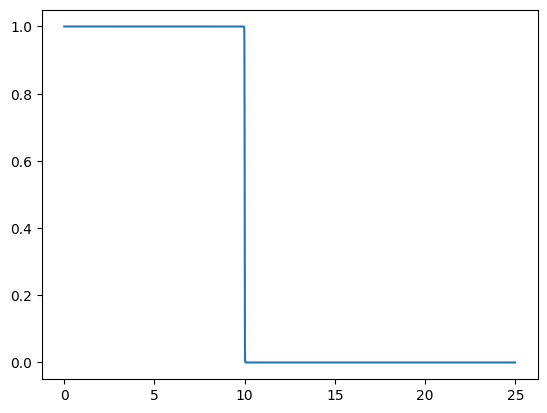

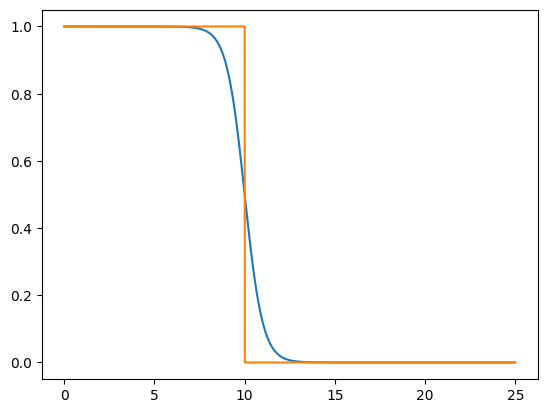

In [ ]:
plt.figure()
plt.plot(tdata, c1)
plt.show()

plt.figure()
plt.plot(tdata, 0.5+0.5*np.tanh(1*(10-tdata)))
plt.plot(tdata, np.heaviside(10-tdata, 1))
plt.show()

In [ ]:
###simulation of equations###
time = 25 #time of the series
fs = 200 #sampling frequency
tdata = np.arange(0, time, 1/fs) #array of time data
tdatapoint = len(tdata) #length of the time data
sim = 1000 #simulation number
c = np.heaviside(list(tdata - 10), 1) #heaviside step function to allow the coupling 
c1 = np.heaviside(list(10 - tdata), 1)
#plc = c[np.where(c!=0)].shape[0] #location where the [c] is NOT ZERO.
#c[np.where(c!=0)] = np.linspace(np.min(c), np.max(c), plc)**(1) #replace the heaviside function to a certain function instead of just one step value

nmean = np.array([0.0, 0.0, 0.0, 0.0])
ncov = np.array([[1.0, 0.0, 0.0, 0.0],
                 [0.0, 1.0, 0.0, 0.0], 
                 [0.0, 0.0, 1.0, 0.0], 
                 [0.0, 0.0, 0.0, 1.0]]) 
x1noise, x2noise, x3noise, x4noise = np.random.multivariate_normal(nmean, ncov, size=(tdatapoint, sim)).T

x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))
x3 = np.zeros((sim, tdatapoint))
x4 = np.zeros((sim, tdatapoint))

for t in tqdm(range(0, tdatapoint, 1)):    
    #x1[:, t] = 0.55*x1[:, t-1]*np.exp((1 - np.abs(x1[:, t-1]))) + x1noise[:,t]
    
    x1[:, t] = 0.55*x1[:, t-1] + x1noise[:,t]
    x2[:, t] = 0.8*x1[:, t-1] + 0.3*x1[:, t-2] + x2noise[:,t]
    x3[:, t] = 0.5*c1[t]*x2[:, t-1] + 0.5*c[t]*x1[:, t-2] + x3noise[:,t]
    
    #example from the paper. 
    #x1[:, t] = 0.55*x1[:, t-1] - 0.8*x1[:, t-2] + c1[t]*x2[:, t-1] + x1noise[:,t]
    #x2[:, t] = 0.55*x2[:, t-1] - 0.8*x2[:, t-2] + c[t]*x1[:,t-1] + x2noise[:,t]

    #example from another paper (review paper). 
    #x1[:, t] = 0.8*x1[:, t-1] + 0.65*x2[:, t-4] + x1noise[:,t]
    #x2[:, t] = 0.6*x2[:, t-1] + 0.6*x4[:, t-5]*x4[:, t-5] + x2noise[:,t]
    #x3[:, t] = 0.5*x3[:, t-3] - 0.6*x1[:, t-1]*x1[:, t-1] + 0.4*x2[:, t-4] + x3noise[:,t]
    #x4[:, t] = 1.2*x4[:, t-1] - 0.7*x4[:, t-2] + x4noise[:,t]

    #x1[:, t] = x1[:, t-1]*x1[:, t-1] + 0.5*x1[:, t-1] + x1noise[:,t]
    #x2[:, t] = x2[:, t-1]*x2[:, t-1] + 0.3*x1[:, t-2] + x2noise[:,t]

100%|██████████| 5000/5000 [00:01<00:00, 2629.50it/s]


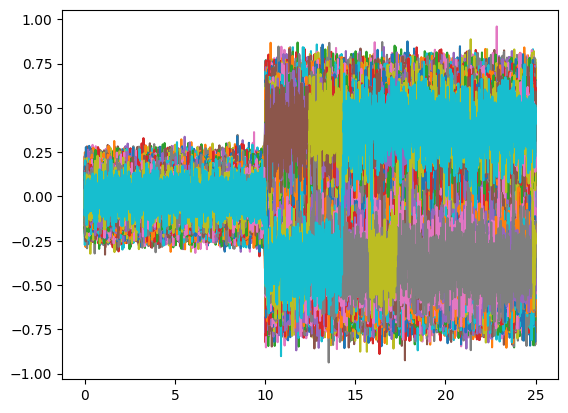

In [ ]:
plt.figure()
for i in range(sim):
    plt.plot(tdata, x2[i])
#plt.xlim(18, 19)
#plt.ylim(-5, 5)
plt.show()

In [ ]:
#surrogate data by [AAFT]
#NOTE: [refined_AAFT_surrogates()] is used for [IAAFT]
ts_x1 = Surrogates(original_data = x1)
surro_x1 = ts_x1.AAFT_surrogates(x1) #surrogate x1 by [aaft] if [AAFT_surrogates] is used
update_x1 = np.append(surro_x1, x1, axis=0) #append data for [surrogate x1] and [x1]

ts_x2 = Surrogates(original_data = x2)
surro_x2 = ts_x2.AAFT_surrogates(x2) #surrogate x2 by [aaft] if [AAFT_surrogates] is used
update_x2 = np.append(surro_x2, x2, axis=0) #append data for [surrogate x2] and [x2]

ts_x3 = Surrogates(original_data = x3)
surro_x3 = ts_x3.AAFT_surrogates(x3) #surrogate x3 by [aaft] if [AAFT_surrogates] is used
update_x3 = np.append(surro_x3, x3, axis=0) #append data for [surrogate x3] and [x3]

NameError: ignored

In [ ]:
num = 1000

numsurro_x1 = np.zeros((num, len(tdata)))
numsurro_x2 = np.zeros((num, len(tdata)))

for n in num: 
    temp_x1 = Surrogates(original_data = x1)

(1000, 5000)


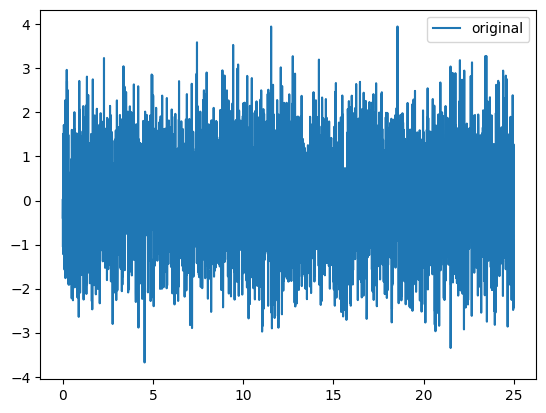

In [ ]:
pst = 2

plt.figure()
#plt.plot(tdata, surro_x1[pst], label='surrogate')
plt.plot(tdata, x1[pst], label='original')
plt.legend(loc='best')
plt.show()

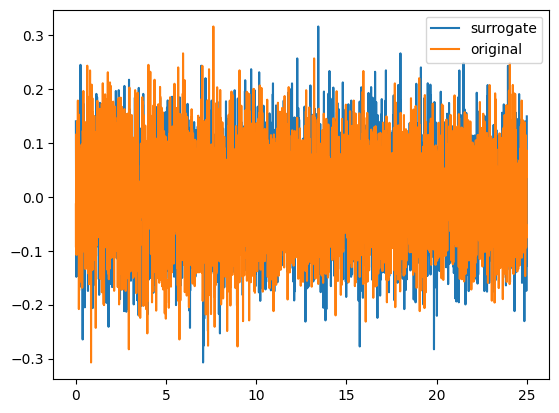

In [ ]:
pst = 1 

plt.figure()
plt.plot(tdata, surro_x3[pst], label='surrogate')
plt.plot(tdata, x3[pst], label='original')
plt.legend(loc='best')
plt.show()

In [ ]:
name = 'nonlinear-small-couple-bi'
folder = 'correct_another_smooth'

In [ ]:
#[mounting] to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#[create] a folder [name]
!mkdir {name}

In [ ]:
#[move] the folder to the specific [directory]
!mv -vn /content/{name} /content/drive/MyDrive/{folder}/{name}

created directory '/content/drive/MyDrive/correct_another_smooth/nonlinear-small-couple-bi/nonlinear-small-couple-bi'
removed directory '/content/nonlinear-small-couple-bi'


In [ ]:
#plotting the figures in a concise manner. 
plt.figure(figsize=(25, 10))
ax1 = plt.subplot(2, 3, (1,2))
ax2 = plt.subplot(2, 3, (4,5))
ax3 = plt.subplot(2, 3, (3,6))
#ax4 = plt.subplot(3, 2, (7,8))

ax1.plot(tdata, x1[0], 'ro-', ms=2, label='one of the simulation of x1')
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('amplitude', fontsize=20)
ax1.tick_params(axis='both', labelsize=20)

ax2.plot(tdata, x2[0], 'go-', ms=2, label='one of the simulation of x2')
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('amplitude', fontsize=20)
ax2.tick_params(axis='both', labelsize=20)

ax3.plot(x1[0], x2[0], 'bo', ms=2, label='phase space of x1 and x2')
ax3.legend(loc='best', fontsize=20)
ax3.set_xlabel('x1', fontsize=20)
ax3.set_ylabel('x2', fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
'''
ax4.plot(tdata, c, 'ko-', ms=2, label='heaviside step function indicates the input')
ax4.legend(loc='best', fontsize=20)
ax4.set_xlabel('time', fontsize=20)
ax4.set_ylabel('amplitude', fontsize=20)
ax4.tick_params(axis='both', labelsize=20)
'''
#plt.savefig(f'/content/drive/MyDrive/{folder}/{name}/data-one_sim{sim}_freq{fs}-{name}.png', dpi=100, bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/data-one_sim{sim}_freq{fs}-{name}.png', dpi=300, bbox_inches='tight')

# Nonparametric Granger causality

In [ ]:
series = np.array([x1, x2]) #NOTE: the data has adjusted
mat_series = np.zeros((len(series), len(series), len(fftfreq(len(tdata), d=(tdata[1]-tdata[0])))))*(1+1j)

#[spectral matrix]#
for i in tqdm(range(mat_series.shape[0])):
    for j in range(mat_series.shape[1]):
        temp_spec, temp_freq = spec(series[i], series[j], tdata)
        mat_series[i,j,:] = temp_spec
        
H, covMat, freq = wilson(mat_series, temp_freq, 50, 1e-10)

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


In [ ]:
#nonparametric granger causality and coherence calculation 
I21 = np.zeros(H.shape[2])*(1+1j) #signal 2 to signal 1
for i in tqdm(range(H.shape[2])):
    Hbar11 = H[0,0,i] + covMat[0,1]/covMat[0,0] * H[0,1,i]
    temp = np.log((mat_series[0,0,i])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
    I21[i] = temp
    
I12 = np.zeros(H.shape[2])*(1+1j) #signal 1 to signal 2
for i in tqdm(range(H.shape[2])):
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log((mat_series[1,1,i])/(Hhat22 * covMat[1,1] * np.conj(Hhat22)))
    I12[i] = temp
    
I12inst = np.zeros(H.shape[2])*(1+1j) #instantaneous of signal 1 and signal 2
for i in tqdm(range(H.shape[2])):
    Hbar11 = H[0,0,i] + covMat[0,1]/covMat[0,0] * H[0,1,i]
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log(((Hbar11*covMat[0,0]*np.conj(Hbar11))*(Hhat22*covMat[1,1]*np.conj(Hhat22)))/(np.linalg.det(mat_series[:,:,i])))
    I12inst[i] = temp
    
Ispect = I21 + I12 + I12inst
cor = 1-np.exp(-Ispect) #coherence

100%|██████████| 5000/5000 [00:00<00:00, 37133.05it/s]


In [ ]:
#retain the data for subplot later
freqf = freq
I12f = I12
I21f = I21

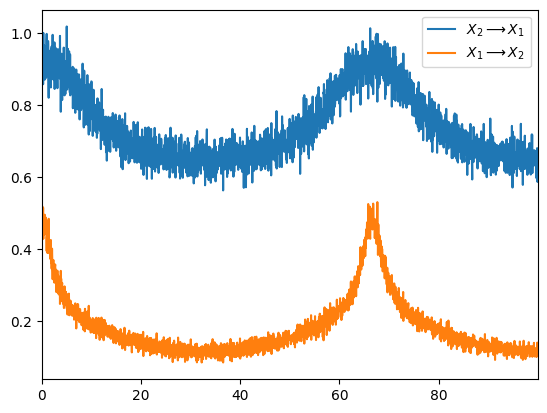

In [ ]:
plt.figure()
plt.plot(fftshift(freqf), fftshift(np.real(I21f)), label='$X_2 \longrightarrow X_1$')
plt.plot(fftshift(freqf), fftshift(np.real(I12f)), label='$X_1 \longrightarrow X_2$')
plt.legend(loc='best')
plt.xlim(0, np.max(fftshift(freq)))
plt.show()

In [ ]:
#save the [data]
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_freq{name}_sim{sim}', freqf)
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_1to2{name}_sim{sim}', I12f)
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_2to1{name}_sim{sim}', I21f)

In [ ]:
######[granger causality] for [time] and [frequency]######
#composing the [spectral matrix]
sample = 100
overlap = 50
f1, t1, z1 = signal.stft(x1, fs, window='hann', nperseg=sample, noverlap=overlap)
f2, t2, z2 = signal.stft(x2, fs, window='hann', nperseg=sample, noverlap=overlap)
conj_z1 = np.conj(z1)
conj_z2 = np.conj(z2)

spec11 = np.mean(z1*conj_z1, axis=0)/(len(tdata))
spec12 = np.mean(z1*conj_z2, axis=0)/(len(tdata))
spec21 = np.mean(z2*conj_z1, axis=0)/(len(tdata))
spec22 = np.mean(z2*conj_z2, axis=0)/(len(tdata))

spec_total = np.array([[spec11, spec12],
                       [spec21, spec22]])

print(signal.check_COLA('hann', sample, overlap, tol=1e-10)) #checking for the suitable windowing for [short-time fourier transform] to ensure the matrix is [positive definite] for later calculation

I21 = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)
I12 = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)
Iinst = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)

for t in tqdm(range(spec_total[0,0,0,:].size)):
    H, covMat, freq = wilson(spec_total[:,:,:,t], f1, 40, 1e-15)
    for f in range(freq.size):
        Hbar11 = H[0,0,f] + covMat[0,1]*H[0,1,f]*covMat[0,0]
        temp2 = np.log((spec_total[0,0,f,t])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
        I21[t, f] = temp2
        
        Hhat22 = H[1,1,f] + (covMat[0,1])/(covMat[1,1]) * H[1,0,f]
        temp1 = np.log((spec_total[1,1,f,t])/(Hhat22 * covMat[1,1] *np.conj(Hhat22)))
        I12[t, f] = temp1

        Hbar11 = H[0,0,f] + covMat[0,1]/covMat[0,0] * H[0,1,f]
        Hhat22 = H[1,1,f] + (covMat[0,1])/(covMat[1,1]) * H[1,0,f] 
        tempint = np.log(((Hbar11*covMat[0,0]*np.conj(Hbar11))*(Hhat22*covMat[1,1]*np.conj(Hhat22)))/(np.linalg.det(mat_series[:,:,f])))
        Iinst[t, f] = tempint

True


100%|██████████| 101/101 [00:18<00:00,  5.35it/s]


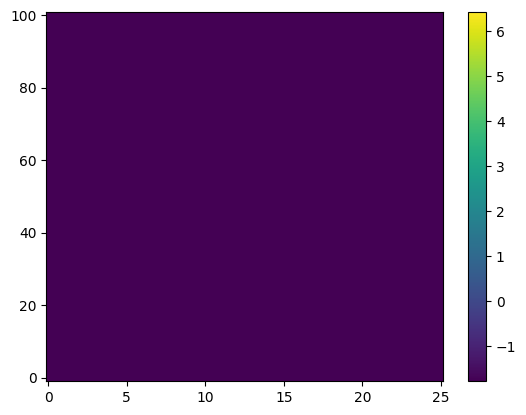

In [ ]:
scalemax = np.max(np.maximum(np.real(I12.T), np.real(I21.T)))
scalemin = np.min(np.minimum(np.real(I12.T), np.real(I21.T)))
plt.figure()
plt.pcolormesh(t2, f2, np.real(Iinst.T), vmin=scalemin, vmax=scalemax)
plt.colorbar()
plt.show()

In [ ]:
#save [data] for [nonparametric GC] for [1 to 2]
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_nonamp_1to2{name}_sim{sim}', I12)
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_nontime_1to2{name}_sim{sim}', t1)
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_nonfreq_1to2{name}_sim{sim}', f1)

#save [data] for [nonparametric GC] for [2 to 1]
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_nonamp_2to1{name}_sim{sim}', I21)
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_nontime_2to1{name}_sim{sim}', t2)
np.save(f'/content/drive/MyDrive/{folder}/{name}/gc_nonfreq_2to1{name}_sim{sim}', f2)

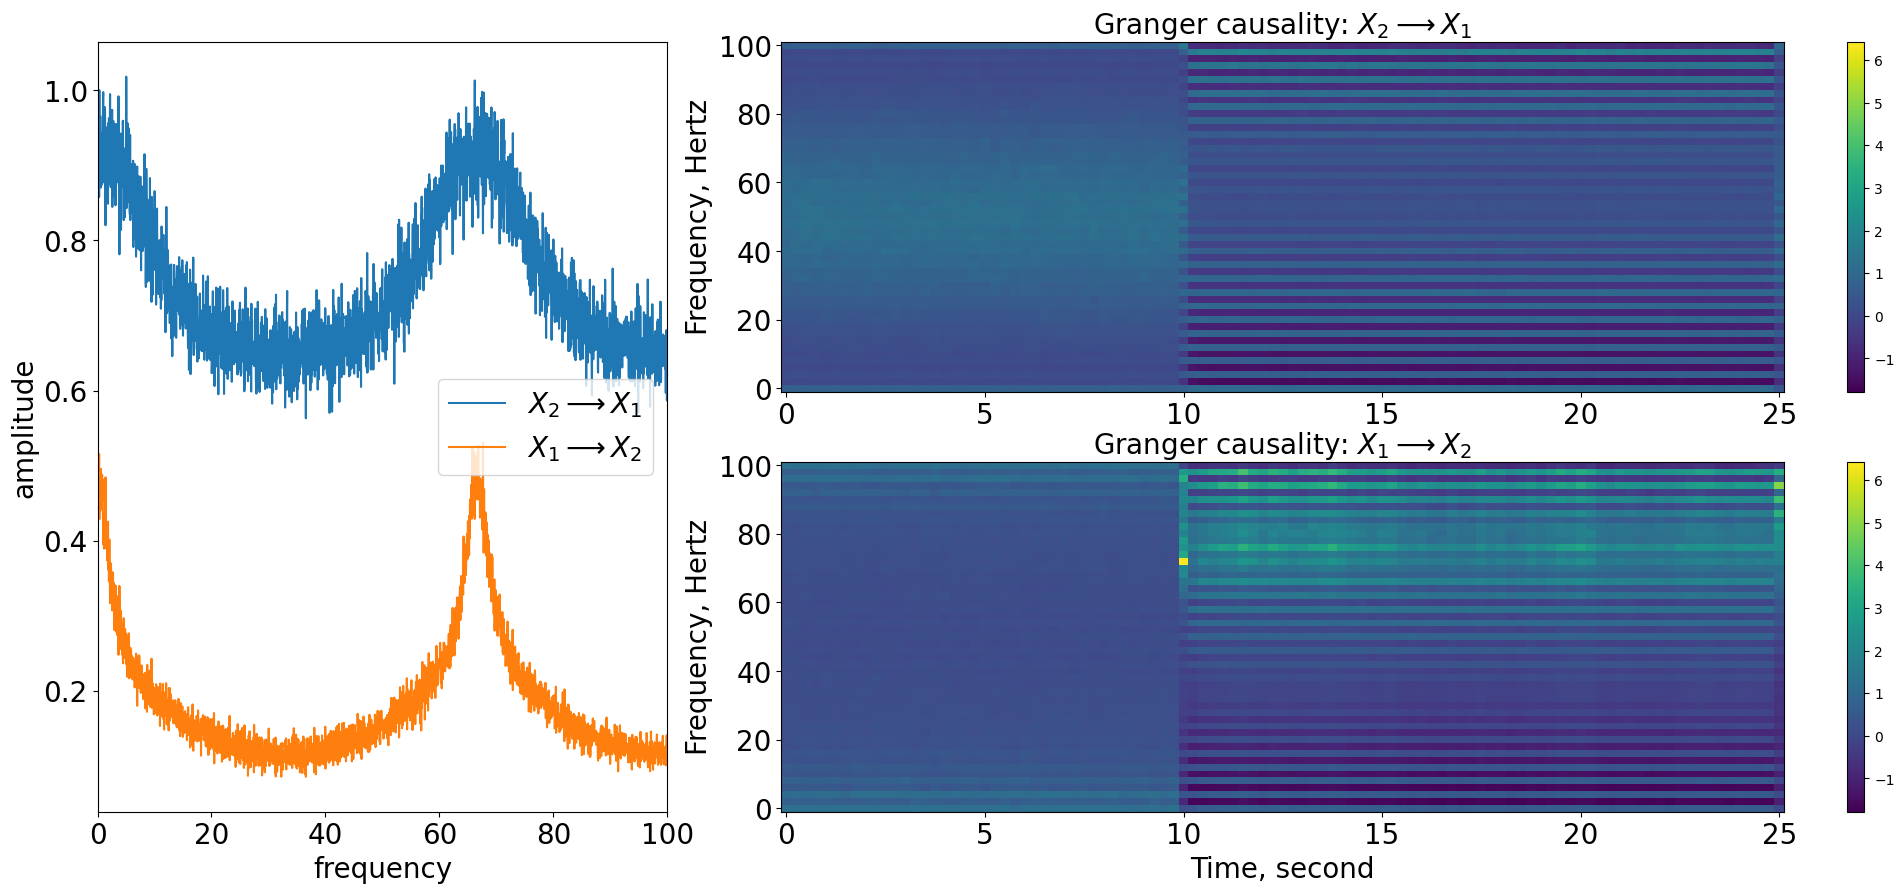

In [ ]:
scalemax = np.max(np.maximum(np.real(I12.T), np.real(I21.T)))
scalemin = np.min(np.minimum(np.real(I12.T), np.real(I21.T)))
fsize = 20

fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot(2, 3, (1, 4))
ax2 = plt.subplot(2, 3, (2, 3))
ax3 = plt.subplot(2, 3, (5, 6))

ax1.plot(fftshift(freqf), fftshift(np.real(I21f)), label='$X_2 \longrightarrow X_1$')
ax1.plot(fftshift(freqf), fftshift(np.real(I12f)), label='$X_1 \longrightarrow X_2$')
#ax1.plot(fftshift(freq), fftshift(np.real(I12inst)), label='$X_1 \longleftrightarrow X_2$')
ax1.legend(loc='best', fontsize=fsize)
ax1.set_xlabel('frequency', fontsize=fsize)
ax1.set_ylabel('amplitude', fontsize=fsize)
#ax1.set_title('Granger Causality')
ax1.set_xlim(0, np.max(fftshift(freq)))
ax1.tick_params(axis='both', labelsize=fsize)

x21 = ax2.pcolormesh(t2, f2, np.real(I21.T), vmin=scalemin, vmax=scalemax)
#ax2.set_xlabel('Time, second', fontsize=fsize)
ax2.set_ylabel('Frequency, Hertz', fontsize=fsize)
ax2.set_title('Granger causality: $X_2 \longrightarrow X_1$', fontsize=fsize)
ax2.tick_params(axis='both', labelsize=fsize)
plt.colorbar(x21, ax=ax2)

x12 = ax3.pcolormesh(t1, f1, np.real(I12.T), vmin=scalemin, vmax=scalemax)
ax3.set_xlabel('Time, second', fontsize=fsize)
ax3.set_ylabel('Frequency, Hertz', fontsize=fsize)
ax3.set_title('Granger causality: $X_1 \longrightarrow X_2$', fontsize=fsize)
ax3.tick_params(axis='both', labelsize=fsize)
plt.colorbar(x12, ax=ax3)
#fig.tight_layout()

plt.savefig(f'/content/drive/MyDrive/{folder}/{name}/granger_sim{sim}-{name}.png', dpi=100, bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/granger_sim{sim}-{name}.png', dpi=300, bbox_inches='tight')

# Transfer Entropy

In [ ]:
x1n = x1[:,:]
x2n = x2[:,:]
series = np.array([x1n, x2n])

range_past = 30
transfer_matrix_series = np.zeros((range_past, len(series), len(series)))
range_t = []

for t in tqdm(range(range_past)):
    past = t
    #size = int(np.ceil(2*(sim*(len(x1n)-past))**(1/3)))
    size = 5
    #print(size)
    
    x1n = x1[:,:]
    x2n = x2[:,:]
    series = np.array([x1n, x2n])
    transfer_matrix = np.zeros((len(series), len(series)))
    
    for i in range(len(series)):
        for j in range(len(series)):
            temp_trans1 = all_cal_transfer(series[i], series[j], size, past, sim)
            temp_trans2 = all_cal_transfer(series[j], series[i], size, past, sim)
            transfer_matrix_series[t, i, j] = (temp_trans1 - temp_trans2)
    range_t.append(past)
range_t = np.array(range_t)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-5-0b29a93a9866>:49: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
<ipython-input-5-0b29a93a9866>:51: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)
100%|██████████| 30/30 [04:19<00:00,  8.66s/it]


In [ ]:
x1n = x1[:,:]
x2n = x2[:,:]

past = 0 #lag number to calculate the transfer entropy. 
win = 100 #window size of the window sliding. 
size = int(np.ceil(2*(sim*win)**(1/3))) #bin size in estimating the PDF for [transfer entropy] calculation; rice's rule on determining the bin size. 
size = int(np.cbrt(size))
#size = int(np.sqrt(size))
#size = 30
print(size)

data_list = {}
series = np.array([x1n, x2n])

for i in tqdm(range(len(series))):
    for j in range(len(series)):
        entro_list = []
        time_list = []
        for t in range(0, len(tdata), 50): #NOTE: the jump of [100] time step is to make the calculation quick; ideally would be good to be [1]. 
            temp_x1n = x1n[:,t:t+win]
            temp_x2n = x2n[:,t:t+win]
            
            series = np.array([temp_x1n, temp_x2n])
            
            temp_trans = all_cal_transfer(series[i], series[j], size, past, sim)
            #print(x1n)
            entro_list.append(temp_trans)
            time_list.append(tdata[t])
            #print(i, j, t/len(tdata), end='\r')
        entro_list = np.array(entro_list)
        data_list.update({f'{i+1} to {j+1}': entro_list})

4


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-0b29a93a9866>:49: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
<ipython-input-5-0b29a93a9866>:51: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)
100%|██████████| 2/2 [00:16<00:00,  8.02s/it]


In [ ]:
###[save] the [net transfer entropy] data###
np.save(f'/content/drive/MyDrive/{folder}/{name}/net_te_sim{sim}_win{win}_lag{past}-{name}', transfer_matrix_series) #net transfer matrix amplitude
np.save(f'/content/drive/MyDrive/{folder}/{name}/net_te-lag-{name}', range_t) #net transfer matrix lag

In [ ]:
###[save] the [transfer entropy] data with the [lag]###
np.save(f'/content/drive/MyDrive/{folder}/{name}/te_sim{sim}_win{win}_lag{past}-{name}', data_list) #transfer entropy all data
np.save(f'/content/drive/MyDrive/{folder}/{name}/te-time-{name}', time_list) #transfer entropy axis

100%|██████████| 2/2 [00:00<00:00, 117.06it/s]


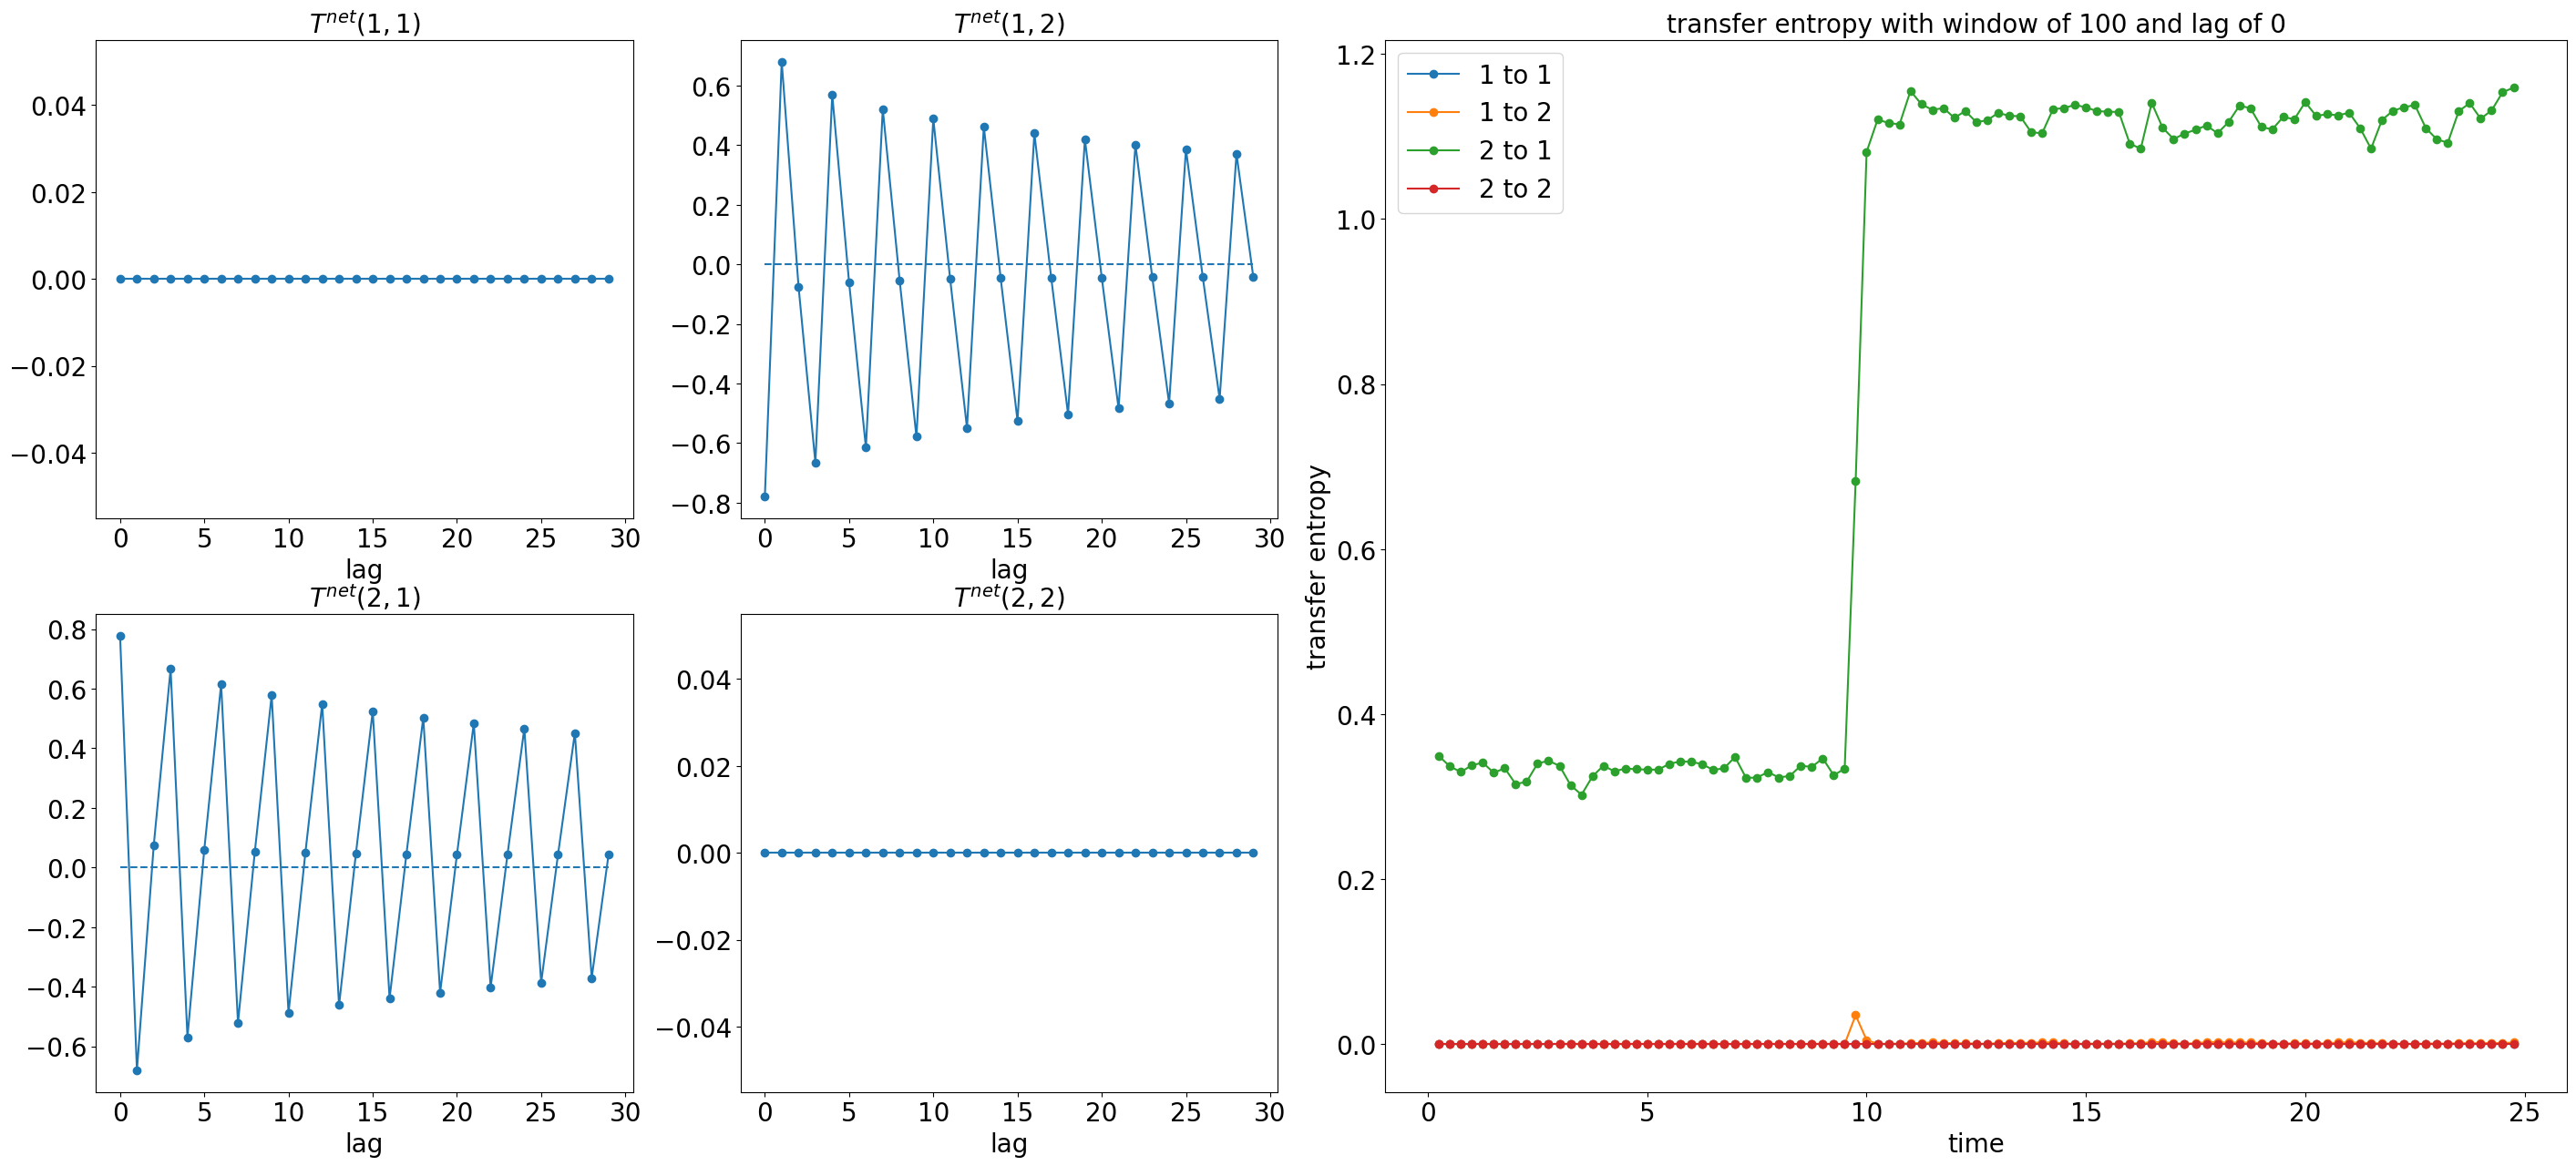

In [ ]:
plt.figure(figsize=(35, 15))
ax1 = plt.subplot(2, 4, 1)
ax2 = plt.subplot(2, 4, 2)
ax3 = plt.subplot(2, 4, 5)
ax4 = plt.subplot(2, 4, 6)
plot_series = np.array([[ax1, ax2], [ax3, ax4]])
ax5 = plt.subplot(2, 4, (3, 8))

for i in tqdm(range(len(series))):
    for j in range(len(series)):
        plot_series[i,j].plot(range_t, transfer_matrix_series[:,i,j], 'o-')
        plot_series[i,j].hlines(0, 0, np.max(range_t), linestyles='dashed')
        #plot_series[i,j].set_xlabel(r'$\alpha, \beta$')
        plot_series[i,j].tick_params(axis='both', labelsize=20)
        plot_series[i,j].set_xlabel('lag', fontsize=20)
        title = i+1, j+1
        plot_series[i,j].set_title('$T^{net}$' + f'${title}$', fontsize=20)
        ax5.plot(np.delete(time_list, 0), np.delete(data_list[f'{i+1} to {j+1}'], 0), 'o-', label=f'{i+1} to {j+1}')
plt.tick_params(axis='both', labelsize=20)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
plt.legend(loc='best', fontsize=20)
plt.xlabel('time', fontsize=20)
plt.ylabel('transfer entropy', fontsize=20)
plt.title(f'transfer entropy with window of {win} and lag of {past}', fontsize=20)

plt.savefig(f'/content/drive/MyDrive/{folder}/{name}/transfer_sim{sim}_win{win}_lag{past}-{name}.png', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/transfer_sim{sim}_win{win}_lag{past}-{name}.pdf', bbox_inches='tight')

# Information rate & information length causality

In [ ]:
#calculate the [information rate causality]#
win = 100
dataratecausal, datatimecausal = info_rate_causal(x1, x2, tdata, win, sim)
#dataratecausal1, datatimecausal1 = info_rate_causal(x1, x3, tdata, win, sim)
#dataratecausal2, datatimecausal2 = info_rate_causal(x2, x3,  tdata, win, sim)

100%|██████████| 99/99 [07:14<00:00,  4.38s/it]


In [ ]:
#calculate the [information rate causality] of the [surrogate data]#
win = 100
surro_dataratecausal, surro_datatimecausal = info_rate_causal_surro(x1, x2, tdata, win, sim)
#surro_dataratecausal1, surro_datatimecausal1 = info_rate_causal_surro(x1, x3, tdata, win, sim)
#surro_dataratecausal2, surro_datatimecausal2 = info_rate_causal_surro(x2, x3, tdata, win, sim)

  0%|          | 0/99 [00:00<?, ?it/s]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  1%|          | 1/99 [00:03<05:05,  3.12s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  2%|▏         | 2/99 [00:06<05:40,  3.51s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  3%|▎         | 3/99 [00:10<05:47,  3.62s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  4%|▍         | 4/99 [00:14<05:48,  3.67s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  5%|▌         | 5/99 [00:19<06:30,  4.15s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  6%|▌         | 6/99 [00:23<06:38,  4.29s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  7%|▋         | 7/99 [00:26<05:53,  3.84s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  8%|▊         | 8/99 [00:29<05:24,  3.56s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


  9%|▉         | 9/99 [00:33<05:10,  3.45s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 10%|█         | 10/99 [00:36<05:05,  3.44s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 11%|█         | 11/99 [00:39<04:48,  3.28s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 12%|█▏        | 12/99 [00:42<04:37,  3.19s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 13%|█▎        | 13/99 [00:45<04:27,  3.12s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 14%|█▍        | 14/99 [00:48<04:32,  3.20s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 15%|█▌        | 15/99 [00:51<04:27,  3.19s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 16%|█▌        | 16/99 [00:54<04:18,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 17%|█▋        | 17/99 [00:57<04:11,  3.06s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 18%|█▊        | 18/99 [01:00<04:10,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 19%|█▉        | 19/99 [01:04<04:17,  3.21s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 20%|██        | 20/99 [01:07<04:07,  3.13s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 21%|██        | 21/99 [01:10<03:59,  3.07s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 22%|██▏       | 22/99 [01:13<03:53,  3.03s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 23%|██▎       | 23/99 [01:16<03:57,  3.13s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 24%|██▍       | 24/99 [01:19<03:57,  3.16s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 25%|██▌       | 25/99 [01:22<03:49,  3.10s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 26%|██▋       | 26/99 [01:25<03:43,  3.06s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 27%|██▋       | 27/99 [01:28<03:39,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 28%|██▊       | 28/99 [01:32<03:46,  3.20s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 29%|██▉       | 29/99 [01:35<03:39,  3.13s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 30%|███       | 30/99 [01:38<03:32,  3.07s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 31%|███▏      | 31/99 [01:41<03:25,  3.02s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 32%|███▏      | 32/99 [01:44<03:26,  3.08s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 33%|███▎      | 33/99 [01:47<03:29,  3.17s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 34%|███▍      | 34/99 [01:50<03:21,  3.10s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 35%|███▌      | 35/99 [01:53<03:15,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 36%|███▋      | 36/99 [01:56<03:11,  3.03s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 37%|███▋      | 37/99 [02:00<03:16,  3.17s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 38%|███▊      | 38/99 [02:03<03:12,  3.15s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 39%|███▉      | 39/99 [02:06<03:05,  3.10s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 40%|████      | 40/99 [02:09<03:00,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 41%|████▏     | 41/99 [02:12<02:59,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 42%|████▏     | 42/99 [02:15<03:02,  3.20s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 43%|████▎     | 43/99 [02:18<02:54,  3.12s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 44%|████▍     | 44/99 [02:21<02:48,  3.06s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 45%|████▌     | 45/99 [02:24<02:43,  3.02s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 46%|████▋     | 46/99 [02:27<02:46,  3.14s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 47%|████▋     | 47/99 [02:31<02:44,  3.16s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 48%|████▊     | 48/99 [02:34<02:37,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 49%|████▉     | 49/99 [02:37<02:32,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 51%|█████     | 50/99 [02:40<02:30,  3.07s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 52%|█████▏    | 51/99 [02:43<02:33,  3.20s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 53%|█████▎    | 52/99 [02:46<02:26,  3.13s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 54%|█████▎    | 53/99 [02:49<02:21,  3.07s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 55%|█████▍    | 54/99 [02:52<02:16,  3.04s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 56%|█████▌    | 55/99 [02:55<02:17,  3.13s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 57%|█████▋    | 56/99 [02:59<02:16,  3.17s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 58%|█████▊    | 57/99 [03:02<02:10,  3.10s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 59%|█████▊    | 58/99 [03:05<02:05,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 60%|█████▉    | 59/99 [03:08<02:02,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 61%|██████    | 60/99 [03:11<02:04,  3.19s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 62%|██████▏   | 61/99 [03:14<01:59,  3.15s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 63%|██████▎   | 62/99 [03:17<01:54,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 64%|██████▎   | 63/99 [03:20<01:49,  3.04s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 65%|██████▍   | 64/99 [03:23<01:48,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 66%|██████▌   | 65/99 [03:27<01:48,  3.18s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 67%|██████▋   | 66/99 [03:30<01:42,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 68%|██████▊   | 67/99 [03:33<01:37,  3.06s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 69%|██████▊   | 68/99 [03:35<01:33,  3.02s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 70%|██████▉   | 69/99 [03:39<01:34,  3.15s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 71%|███████   | 70/99 [03:42<01:31,  3.14s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 72%|███████▏  | 71/99 [03:45<01:26,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 73%|███████▎  | 72/99 [03:48<01:22,  3.06s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 74%|███████▎  | 73/99 [03:51<01:20,  3.08s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 75%|███████▍  | 74/99 [03:55<01:19,  3.19s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 76%|███████▌  | 75/99 [03:58<01:14,  3.12s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 77%|███████▋  | 76/99 [04:00<01:10,  3.07s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 78%|███████▊  | 77/99 [04:03<01:06,  3.03s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 79%|███████▉  | 78/99 [04:07<01:05,  3.13s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 80%|███████▉  | 79/99 [04:10<01:03,  3.15s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 81%|████████  | 80/99 [04:13<00:58,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 82%|████████▏ | 81/99 [04:16<00:54,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 83%|████████▎ | 82/99 [04:19<00:51,  3.05s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 84%|████████▍ | 83/99 [04:22<00:51,  3.19s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 85%|████████▍ | 84/99 [04:25<00:46,  3.12s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 86%|████████▌ | 85/99 [04:28<00:42,  3.06s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 87%|████████▋ | 86/99 [04:31<00:39,  3.03s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 88%|████████▊ | 87/99 [04:35<00:37,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 89%|████████▉ | 88/99 [04:38<00:34,  3.17s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 90%|████████▉ | 89/99 [04:41<00:31,  3.18s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 91%|█████████ | 90/99 [04:44<00:28,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 92%|█████████▏| 91/99 [04:47<00:24,  3.10s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 93%|█████████▎| 92/99 [04:51<00:22,  3.23s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 94%|█████████▍| 93/99 [04:54<00:18,  3.15s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 95%|█████████▍| 94/99 [04:57<00:15,  3.09s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 96%|█████████▌| 95/99 [04:59<00:12,  3.04s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 97%|█████████▋| 96/99 [05:03<00:09,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 98%|█████████▊| 97/99 [05:06<00:06,  3.18s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


 99%|█████████▉| 98/99 [05:09<00:03,  3.11s/it]

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...
Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


100%|██████████| 99/99 [05:12<00:00,  3.16s/it]


In [ ]:
###[save] the [info rate causality] data###
np.save(f'/content/drive/MyDrive/{folder}/{name}/info_rate-causal-{name}_sim{sim}', dataratecausal) #[information rate causality] data
np.save(f'/content/drive/MyDrive/{folder}/{name}/info_rate-causal-time-{name}_sim{sim}', datatimecausal) #[information rate causality] time data

In [ ]:
#calculate the [information length causality]#
lencausal1to2 = []
lencausal2to1 = []

for i in range(len(datatimecausal)):
    lencausal1to2.append(np.cumsum(np.sqrt(dataratecausal['rate_1to2'][i]) * (datatimecausal[i][1] - datatimecausal[i][0])))
    lencausal2to1.append(np.cumsum(np.sqrt(dataratecausal['rate_2to1'][i]) * (datatimecausal[i][1] - datatimecausal[i][0])))

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 1, (1))
#ax2 = fig.add_subplot(1, 2, (2))
for i in range(len(datatimecausal)):
    ax1.plot(datatimecausal[i], dataratecausal['rate_1to2'][i], 'ro-', ms=2, label='$\Gamma^2$ 1 to 2')
    ax1.plot(datatimecausal[i], dataratecausal['rate_2to1'][i], 'bo-', ms=2, label='$\Gamma^2$ 2 to 1')
    #ax1.plot(surro_datatimecausal[i], surro_dataratecausal['rate_1to2'][i], 'k-', ms=2, label='thres 1 to 2')
    #ax1.plot(surro_datatimecausal[i], surro_dataratecausal['rate_2to1'][i], 'm-', ms=2, label='thres 2 to 1')
    #ax1.plot(surro_datatimecausal[i], surro_dataratecausal['rate_1to2'][i], 'k-', ms=2, label='thres 1 to 2')
    #ax1.plot(surro_datatimecausal[i], surro_dataratecausal['rate_2to1'][i], 'm-', ms=2, label='thres 2 to 1')
    #ax2.plot(datatimecausal[i], lencausal1to2[i], 'ro-', ms=2, label='$\mathcal{L}$ 1 to 2')
    #ax2.plot(datatimecausal[i], lencausal2to1[i], 'bo-', ms=2, label='$\mathcal{L}$ 2 to 1')


ax1.set_xlim(9.6, 10.4)
#ax1.set_ylim(0, 100)
ax1.tick_params(axis='both', labelsize=20)
#ax1.set_yscale('log')
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('information rate square, $\Gamma^2$', fontsize=20)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
'''
#ax2.set_xlim(9.6, 10.4)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('information length, $\mathcal{L}$', fontsize=20)
'''
handles1, labels1 = ax1.get_legend_handles_labels()
display = [0,1]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best', fontsize=20)
'''
handles2, labels2 = ax2.get_legend_handles_labels()
display = [0,1]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best', fontsize=20)
'''
#plt.savefig(f'/content/drive/MyDrive/{folder}/{name}/enl_causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/correct/{name}/enl_causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

IndexError: ignored

<Figure size 1200x600 with 1 Axes>

In [ ]:
for i in range(0, len(datatimecausal), 1): 
    print('1to2:', check_hist(dataratecausal['rate_1to2'][i], 3)) 
    print('2to1:', check_hist(dataratecausal['rate_2to1'][i], 3))
    print(check_hist(np.append(dataratecausal['rate_1to2'][i], dataratecausal['rate_2to1'][i]), 3))
    print(datatimecausal[i][0])
    print('-'*50)

1to2: []
2to1: []
[86]
0.005
--------------------------------------------------
1to2: []
2to1: [35]
[74 84]
0.255
--------------------------------------------------
1to2: []
2to1: []
[]
0.505
--------------------------------------------------
1to2: []
2to1: []
[]
0.755
--------------------------------------------------
1to2: [25]
2to1: []
[25]
1.0050000000000001
--------------------------------------------------
1to2: []
2to1: []
[]
1.2550000000000001
--------------------------------------------------
1to2: []
2to1: []
[]
1.5050000000000001
--------------------------------------------------
1to2: []
2to1: []
[]
1.7550000000000001
--------------------------------------------------
1to2: []
2to1: []
[]
2.005
--------------------------------------------------
1to2: []
2to1: [3]
[ 1 11 52]
2.255
--------------------------------------------------
1to2: []
2to1: [1]
[50]
2.505
--------------------------------------------------
1to2: [44]
2to1: []
[71]
2.755
----------------------------------

In [ ]:
#calculate the [information length causality]#
lencausal1to21 = []
lencausal2to11 = []

for i in range(len(datatimecausal)):
    lencausal1to21.append(np.cumsum(np.sqrt(dataratecausal1['rate_1to2'][i]) * (datatimecausal1[i][1] - datatimecausal1[i][0])))
    lencausal2to11.append(np.cumsum(np.sqrt(dataratecausal1['rate_2to1'][i]) * (datatimecausal1[i][1] - datatimecausal1[i][0])))

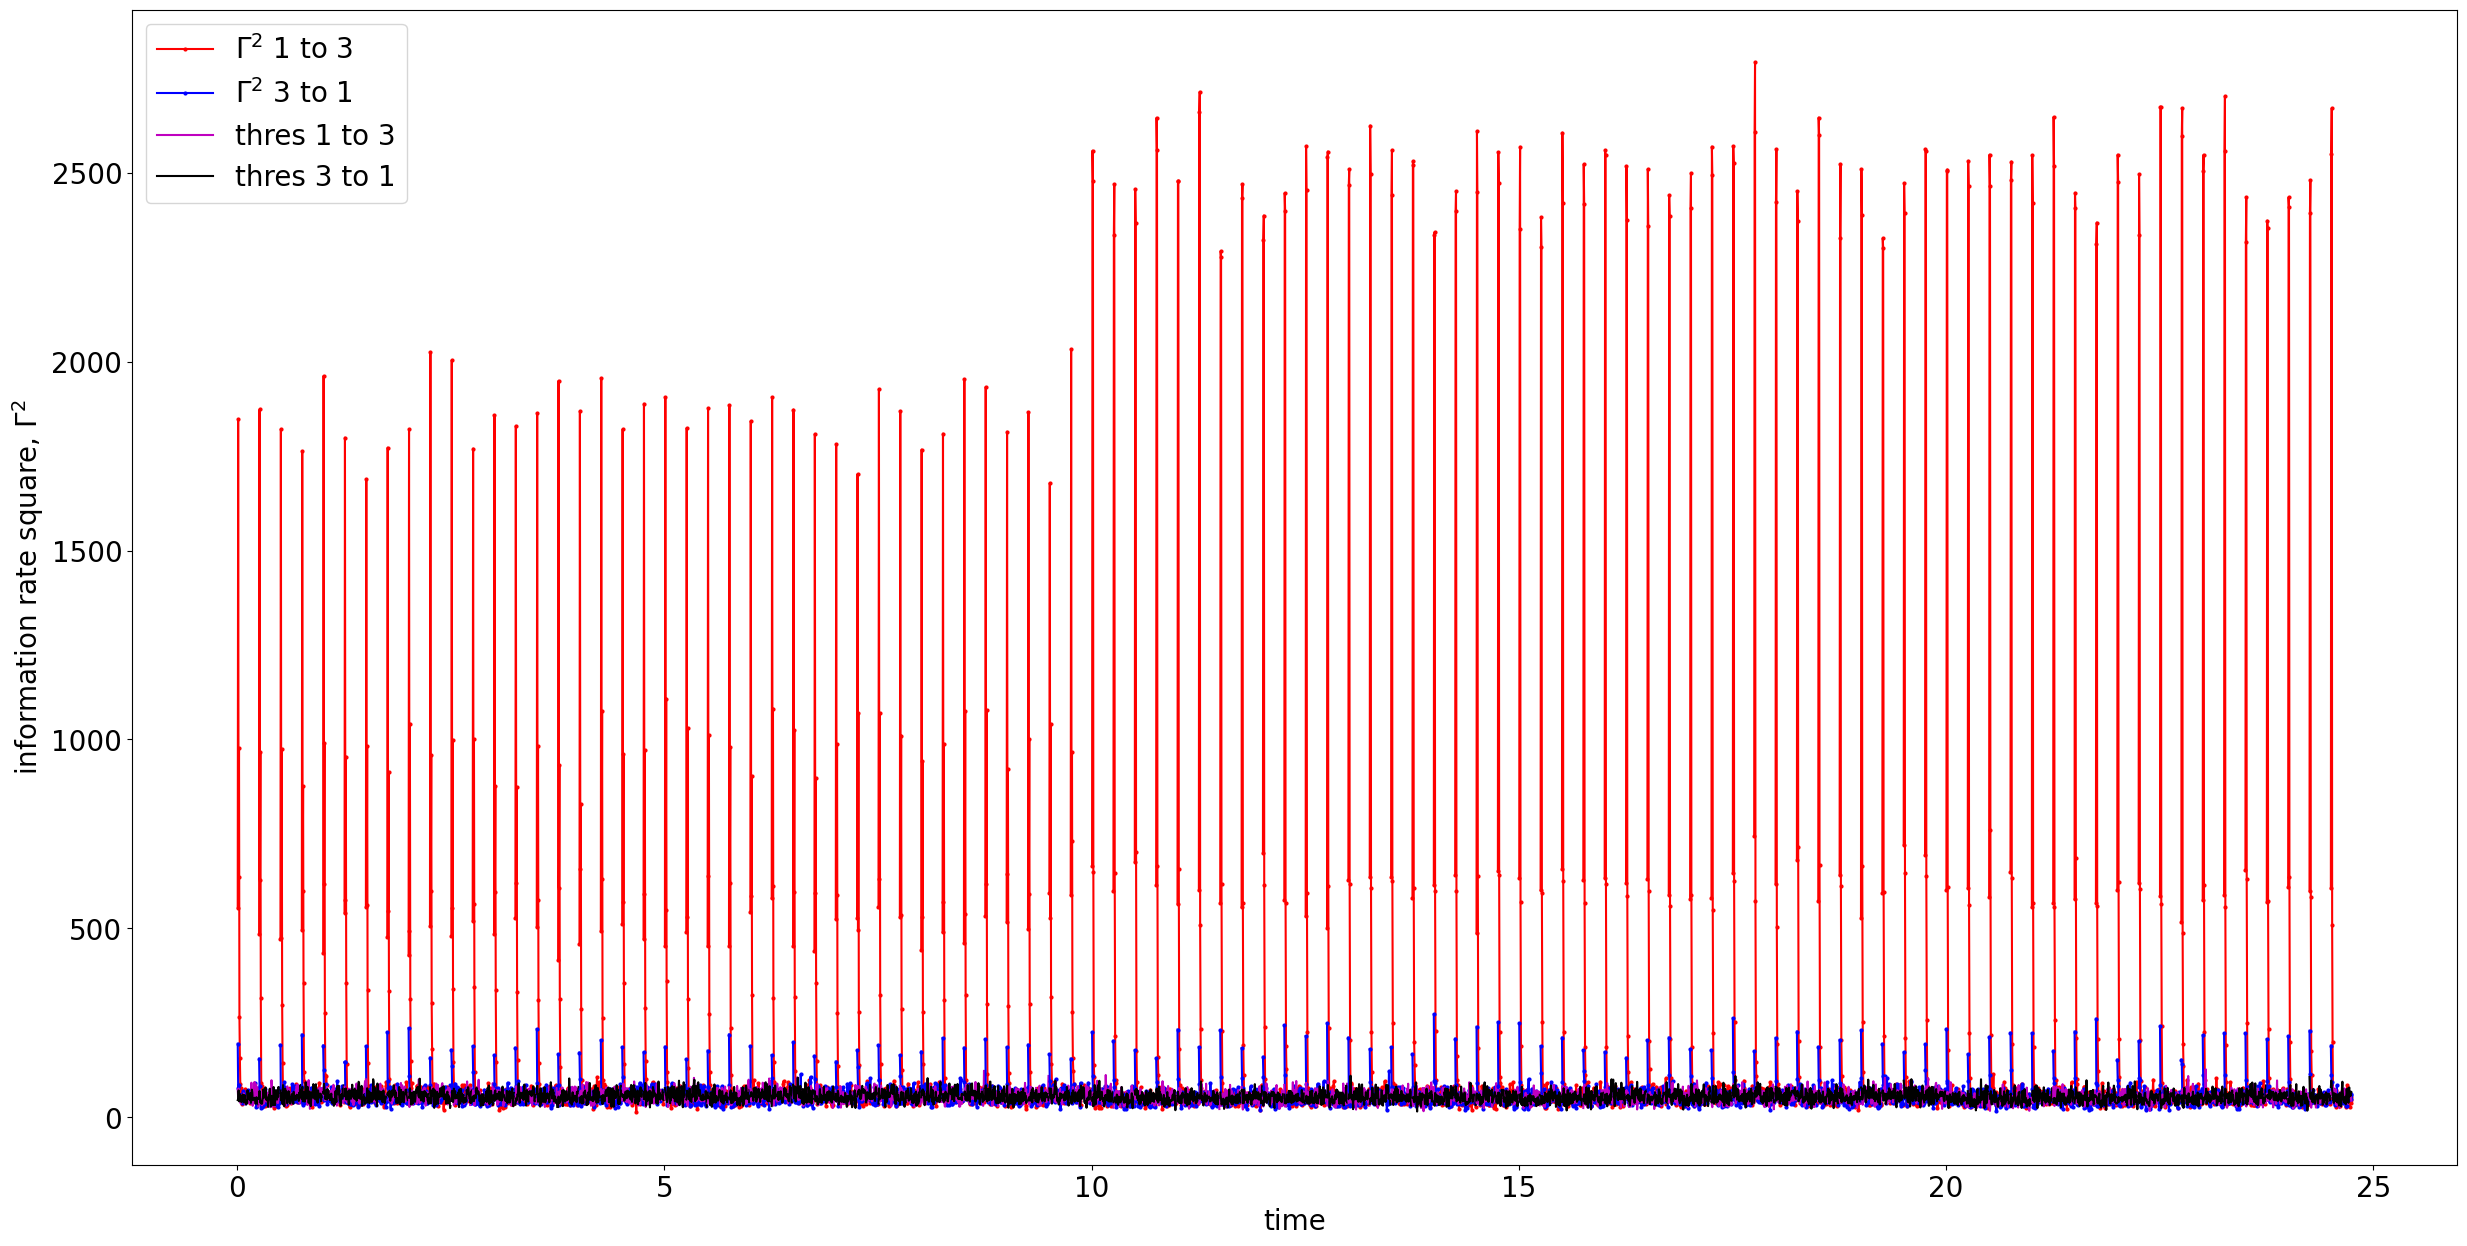

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(1, 1, (1))
#ax2 = fig.add_subplot(1, 2, (2))
for i in range(len(datatimecausal1)):
    ax1.plot(datatimecausal1[i], dataratecausal1['rate_1to2'][i], 'ro-', ms=2, label='$\Gamma^2$ 1 to 3')
    ax1.plot(datatimecausal1[i], dataratecausal1['rate_2to1'][i], 'bo-', ms=2, label='$\Gamma^2$ 3 to 1')
    ax1.plot(surro_datatimecausal1[i], surro_dataratecausal1['rate_1to2'][i], 'm-', ms=2, label='thres 1 to 3')
    ax1.plot(surro_datatimecausal1[i], surro_dataratecausal1['rate_2to1'][i], 'k-', ms=2, label='thres 3 to 1')
    #ax2.plot(datatimecausal1[i], lencausal1to21[i], 'ro-', ms=2, label='$\mathcal{L}$ 1 to 3')
    #ax2.plot(datatimecausal1[i], lencausal2to11[i], 'bo-', ms=2, label='$\mathcal{L}$ 3 to 1')

#ax1.set_xlim(9.6, 10.4)
ax1.tick_params(axis='both', labelsize=20)
#ax1.set_yscale('log')
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('information rate square, $\Gamma^2$', fontsize=20)
'''
#ax2.set_xlim(9.6, 10.4)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('information length, $\mathcal{L}$', fontsize=20)
'''
handles1, labels1 = ax1.get_legend_handles_labels()
display = [0,1,2,3]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best', fontsize=20)
'''
handles2, labels2 = ax2.get_legend_handles_labels()
display = [0,1]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best', fontsize=20)
'''
#plt.savefig(f'/content/drive/MyDrive/{name}/enl_causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/enl_causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

In [ ]:
for i in range(len(datatimecausal1)):
    print('1to3', check_hist(dataratecausal1['rate_1to2'][i], 3))
    print('3to1', check_hist(dataratecausal1['rate_2to1'][i], 3))
    print(check_hist(np.append(dataratecausal1['rate_1to2'][i], dataratecausal1['rate_2to1'][i]), 3))
    print(np.append(datatimecausal1[i], datatimecausal1[i])[49:51])
    print(datatimecausal1[i][0])
    print('-'*50)

1to3 []
3to1 [1]
[13]
[0.005 0.01 ]
0.005
--------------------------------------------------
1to3 [44]
3to1 [16]
[44 45]
[0.255 0.26 ]
0.255
--------------------------------------------------
1to3 []
3to1 []
[]
[0.505 0.51 ]
0.505
--------------------------------------------------
1to3 [7]
3to1 []
[7]
[0.755 0.76 ]
0.755
--------------------------------------------------
1to3 []
3to1 []
[]
[1.005 1.01 ]
1.0050000000000001
--------------------------------------------------
1to3 []
3to1 []
[]
[1.255 1.26 ]
1.2550000000000001
--------------------------------------------------
1to3 []
3to1 []
[]
[1.505 1.51 ]
1.5050000000000001
--------------------------------------------------
1to3 []
3to1 []
[86]
[1.755 1.76 ]
1.7550000000000001
--------------------------------------------------
1to3 []
3to1 []
[88]
[2.005 2.01 ]
2.005
--------------------------------------------------
1to3 []
3to1 []
[]
[2.255 2.26 ]
2.255
--------------------------------------------------
1to3 [46]
3to1 [18]
[31 36 46]

In [ ]:
#calculate the [information length causality]#
lencausal1to22 = []
lencausal2to12 = []

for i in range(len(datatimecausal)):
    lencausal1to22.append(np.cumsum(np.sqrt(dataratecausal2['rate_1to2'][i]) * (datatimecausal2[i][1] - datatimecausal2[i][0])))
    lencausal2to12.append(np.cumsum(np.sqrt(dataratecausal2['rate_2to1'][i]) * (datatimecausal2[i][1] - datatimecausal2[i][0])))

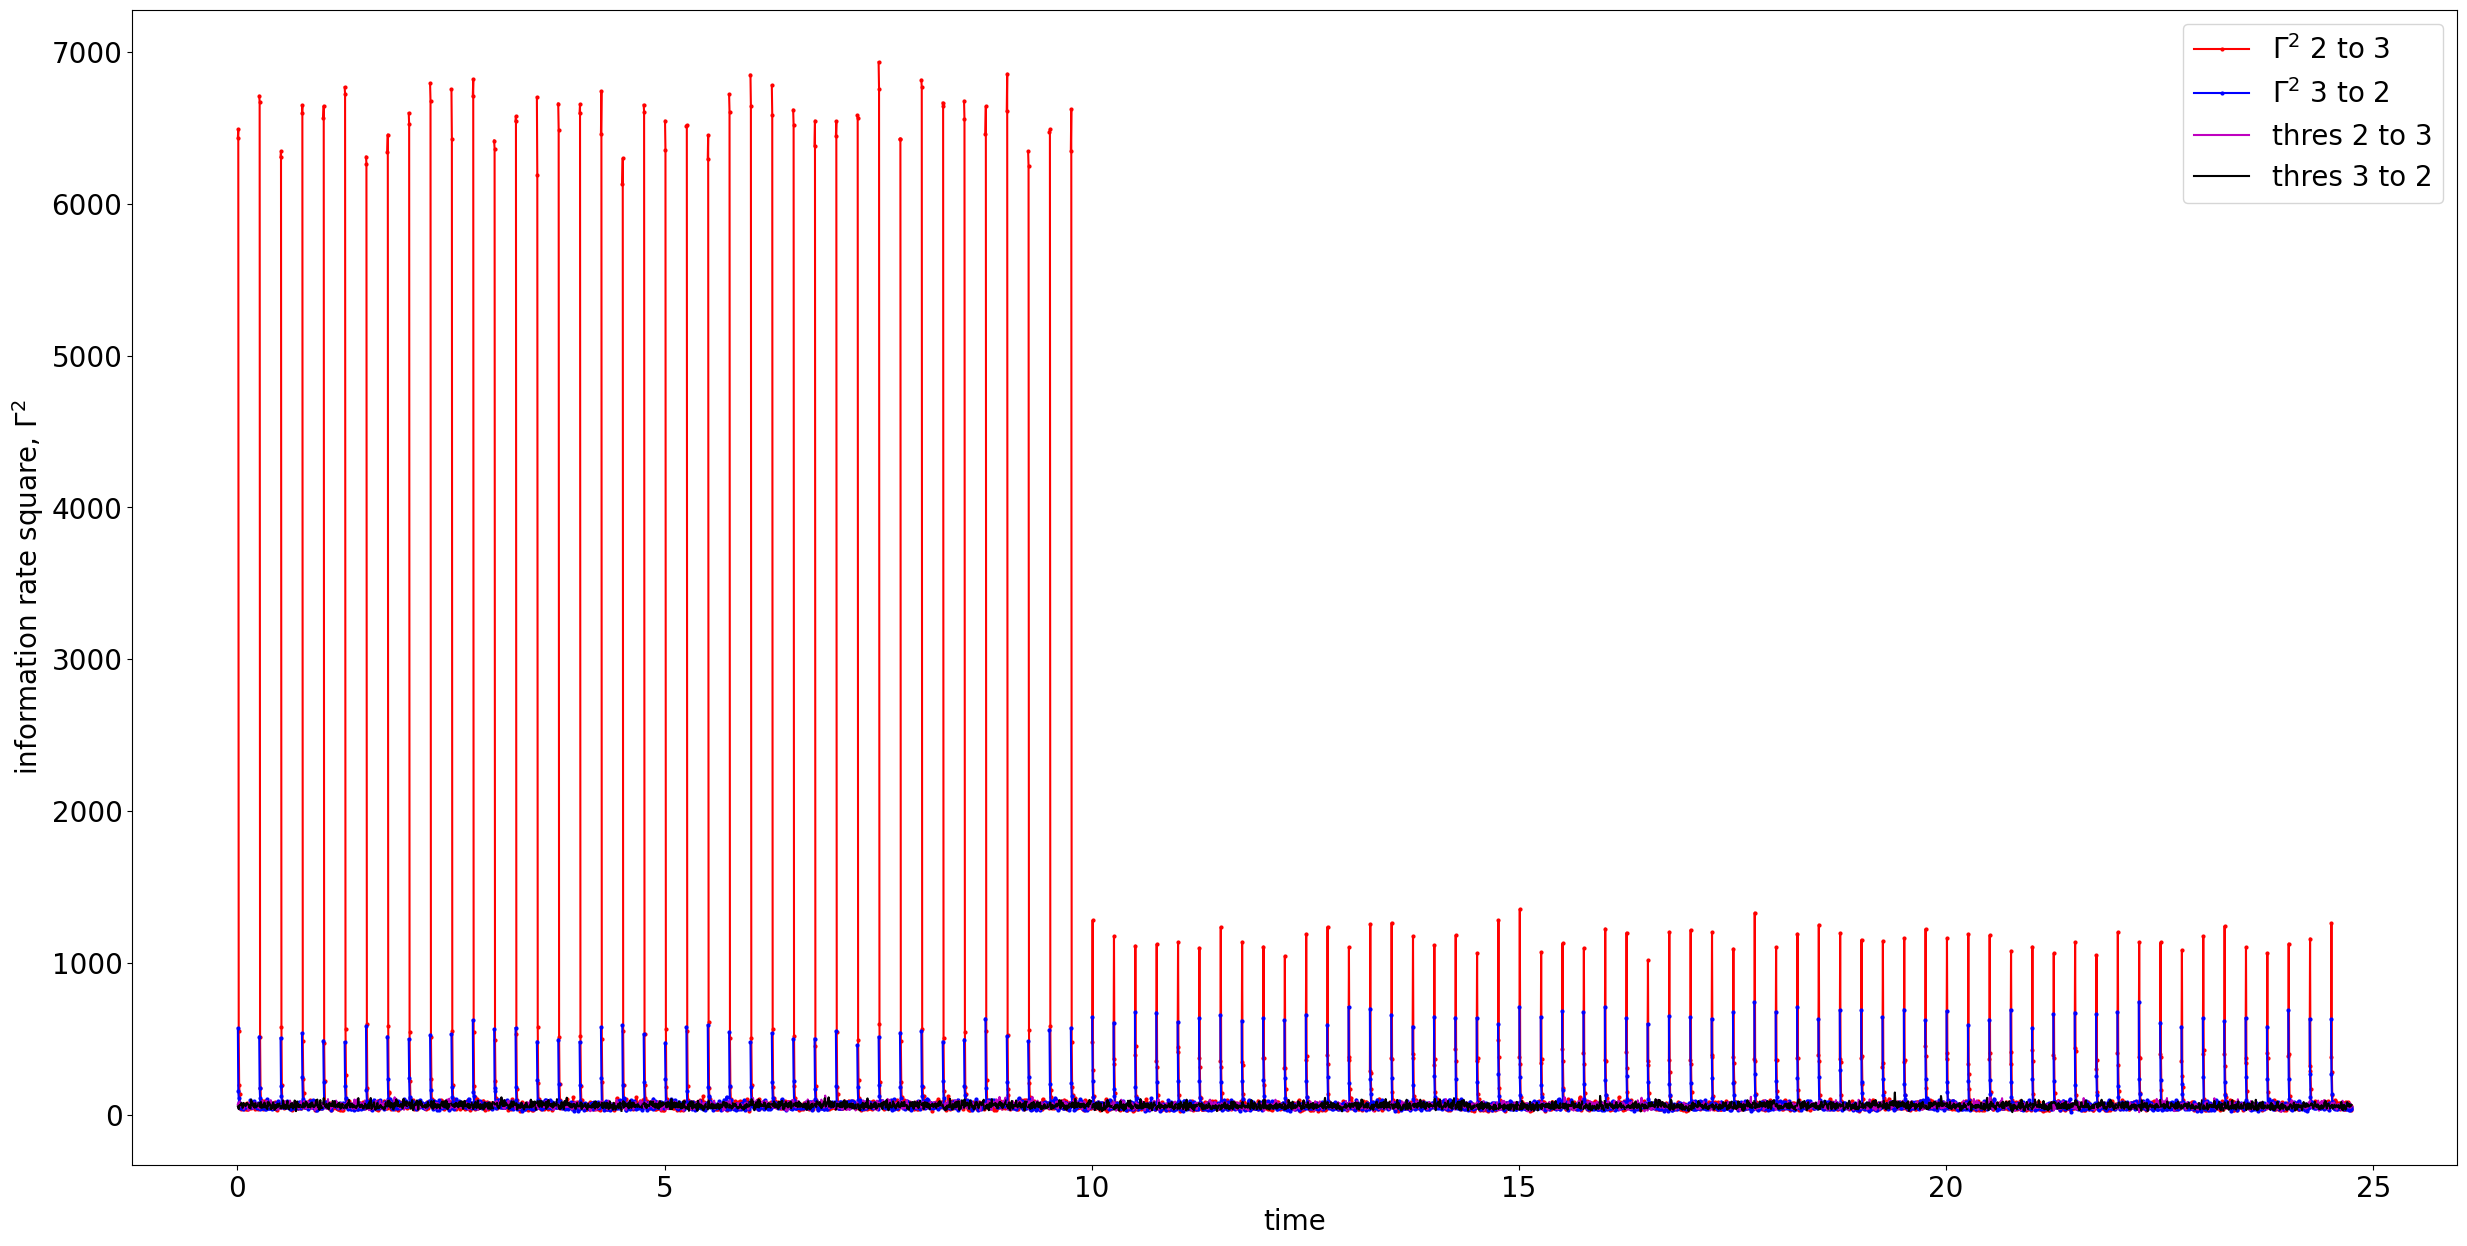

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(1, 1, (1))
#ax2 = fig.add_subplot(1, 2, (2))
for i in range(len(datatimecausal1)):
    ax1.plot(datatimecausal2[i], dataratecausal2['rate_1to2'][i], 'ro-', ms=2, label='$\Gamma^2$ 2 to 3')
    ax1.plot(datatimecausal2[i], dataratecausal2['rate_2to1'][i], 'bo-', ms=2, label='$\Gamma^2$ 3 to 2')
    ax1.plot(surro_datatimecausal2[i], surro_dataratecausal2['rate_1to2'][i], 'm-', ms=2, label='thres 2 to 3')
    ax1.plot(surro_datatimecausal2[i], surro_dataratecausal2['rate_2to1'][i], 'k-', ms=2, label='thres 3 to 2')
    #ax2.plot(datatimecausal2[i], lencausal1to22[i], 'ro-', ms=2, label='$\mathcal{L}$ 2 to 3')
    #ax2.plot(datatimecausal2[i], lencausal2to12[i], 'bo-', ms=2, label='$\mathcal{L}$ 3 to 2')

#ax1.set_xlim(9.6, 10.4)
ax1.tick_params(axis='both', labelsize=20)
#ax1.set_yscale('log')
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('information rate square, $\Gamma^2$', fontsize=20)
'''
#ax2.set_xlim(9.6, 10.4)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('information length, $\mathcal{L}$', fontsize=20)
'''
handles1, labels1 = ax1.get_legend_handles_labels()
display = [0,1,2,3]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best', fontsize=20)
'''
handles2, labels2 = ax2.get_legend_handles_labels()
display = [0,1]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best', fontsize=20)
'''
#plt.savefig(f'/content/drive/MyDrive/{name}/enl_causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/enl_causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

In [ ]:
for i in range(0, len(datatimecausal2), 1): 
    print('2to3:', check_hist(dataratecausal2['rate_1to2'][i], 3)) 
    print('3to2:', check_hist(dataratecausal1['rate_2to1'][i], 3))
    print(check_hist(np.append(dataratecausal2['rate_1to2'][i], dataratecausal2['rate_2to1'][i]), 3))
    print(datatimecausal2[i][3:5])
    print(np.append(datatimecausal2[i], datatimecausal2[i])[52:54])
    print(datatimecausal2[i][0])
    print('-'*50)

2to3: []
3to2: [1]
[]
[0.02  0.025]
[0.02  0.025]
0.005
--------------------------------------------------
2to3: []
3to2: [16]
[]
[0.27  0.275]
[0.27  0.275]
0.255
--------------------------------------------------
2to3: []
3to2: []
[]
[0.52  0.525]
[0.52  0.525]
0.505
--------------------------------------------------
2to3: []
3to2: []
[]
[0.77  0.775]
[0.77  0.775]
0.755
--------------------------------------------------
2to3: []
3to2: []
[]
[1.02  1.025]
[1.02  1.025]
1.0050000000000001
--------------------------------------------------
2to3: []
3to2: []
[]
[1.27  1.275]
[1.27  1.275]
1.2550000000000001
--------------------------------------------------
2to3: []
3to2: []
[]
[1.52  1.525]
[1.52  1.525]
1.5050000000000001
--------------------------------------------------
2to3: []
3to2: []
[]
[1.77  1.775]
[1.77  1.775]
1.7550000000000001
--------------------------------------------------
2to3: []
3to2: []
[]
[2.02  2.025]
[2.02  2.025]
2.005
------------------------------------------

NameError: ignored

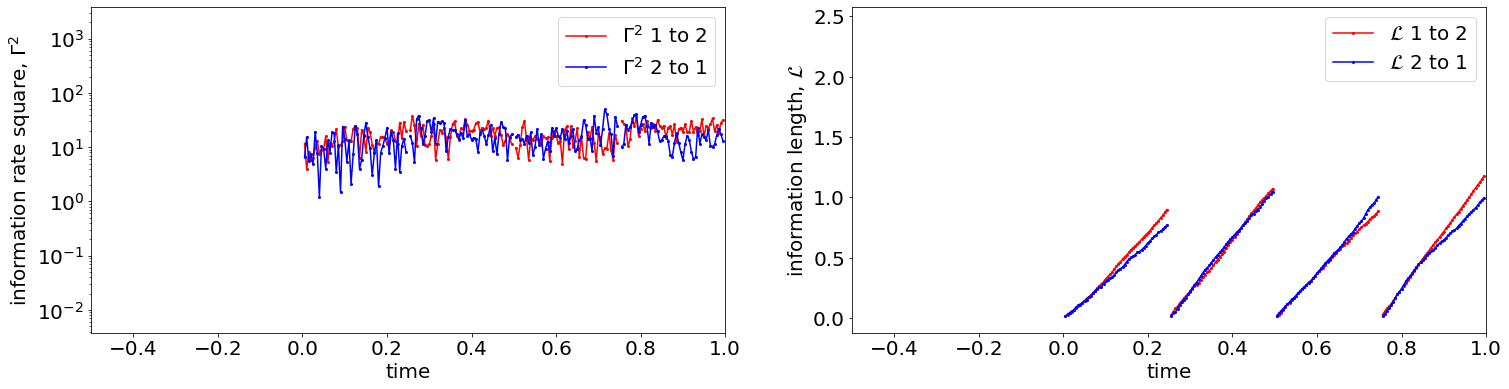

In [ ]:
fig = plt.figure(figsize=(25, 6))
ax1 = fig.add_subplot(1, 2, (1))
ax2 = fig.add_subplot(1, 2, (2))
for i in range(len(datatimecausal)):
    ax1.plot(datatimecausal[i], dataratecausal['rate_1to2'][i], 'ro-', ms=2, label='$\Gamma^2$ 1 to 2')
    ax1.plot(datatimecausal[i], dataratecausal['rate_2to1'][i], 'bo-', ms=2, label='$\Gamma^2$ 2 to 1')

    ax2.plot(datatimecausal[i], lencausal1to2[i], 'ro-', ms=2, label='$\mathcal{L}$ 1 to 2')
    ax2.plot(datatimecausal[i], lencausal2to1[i], 'bo-', ms=2, label='$\mathcal{L}$ 2 to 1')

ax1.set_xlim(-0.5, 1.0)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_yscale('log')
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('information rate square, $\Gamma^2$', fontsize=20)

ax2.set_xlim(-0.5, 1.0)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('information length, $\mathcal{L}$', fontsize=20)

handles1, labels1 = ax1.get_legend_handles_labels()
display = [0,1]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best', fontsize=20)

handles2, labels2 = ax2.get_legend_handles_labels()
display = [0,1]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best', fontsize=20)

plt.savefig(f'/content/drive/MyDrive/{name}/enl_causal-info_sim{sim}_win{win}-str-{name}.pdf', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/enl_causal-info_sim{sim}_win{win}-str-{name}.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(25, 6))
ax1 = fig.add_subplot(1, 2, (1))
ax2 = fig.add_subplot(1, 2, (2))
for i in range(len(datatimecausal)):
    ax1.plot(datatimecausal[i], dataratecausal['rate_1to2'][i], 'ro-', ms=2, label='$\Gamma^2$ 1 to 2')
    ax1.plot(datatimecausal[i], dataratecausal['rate_2to1'][i], 'bo-', ms=2, label='$\Gamma^2$ 2 to 1')

    ax2.plot(datatimecausal[i], lencausal1to2[i], 'ro-', ms=2, label='$\mathcal{L}$ 1 to 2')
    ax2.plot(datatimecausal[i], lencausal2to1[i], 'bo-', ms=2, label='$\mathcal{L}$ 2 to 1')

#ax1.set_yscale('log')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('information rate square, $\Gamma^2$', fontsize=20)

ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('information length, $\mathcal{L}$', fontsize=20)

handles1, labels1 = ax1.get_legend_handles_labels()
display = [0,1]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best', fontsize=20)

handles2, labels2 = ax2.get_legend_handles_labels()
display = [0,1]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best', fontsize=20)

plt.savefig(f'/content/drive/MyDrive/{name}/causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/causal-info_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

In [ ]:
'''
#estimate the evolution of the [pdf] at different instance via histogram
win = 100
sld = 10
datapdf, datatime = pdf_evol(x1, x2, tdata, win, sld, sim)
'''

In [ ]:
'''
###[save] the [information rate] data###
np.save(f'/content/drive/MyDrive/{name}/info_pdf-{name}', datapdf) #[information rate] data
np.save(f'/content/drive/MyDrive/{name}/info_pdf-time-{name}', datatime) #[information rate] time
'''

# Information rate & information length causality (kernel density estimation)

In [ ]:
#calculate the [information rate causality]#
win = 100
pnt = 100
dataratecausal_kernel, datatimecausal_kernel = info_rate_causal_kernel(x1, x2, tdata, win, sim, pnt)

  1%|          | 1/99 [00:03<05:17,  3.24s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.10/dist-packages/numpy/lib/index_tricks.py:185: RuntimeWarning: invalid value encountered in multiply
  nn[k] = (nn[k]*step+start)
  1%|          | 1/99 [00:03<05:18,  3.25s/it]


ValueError: ignored

In [ ]:
###[save] the [info rate causality] data###
np.save(f'/content/drive/MyDrive/{name}/info_rate-causal-kernel-{name}', dataratecausal_kernel) #[information rate causality] data
np.save(f'/content/drive/MyDrive/{name}/info_rate-causal-time-kernel-{name}', datatimecausal_kernel) #[information rate causality] time data

In [ ]:
#calculate the [information length causality]#
lencausal1to2_kernel = []
lencausal2to1_kernel = []

for i in range(len(datatimecausal_kernel)):
    lencausal1to2_kernel.append(np.cumsum(np.sqrt(dataratecausal_kernel['rate_1to2'][i]) * (datatimecausal_kernel[i][1] - datatimecausal_kernel[i][0])))
    lencausal2to1_kernel.append(np.cumsum(np.sqrt(dataratecausal_kernel['rate_2to1'][i]) * (datatimecausal_kernel[i][1] - datatimecausal_kernel[i][0])))

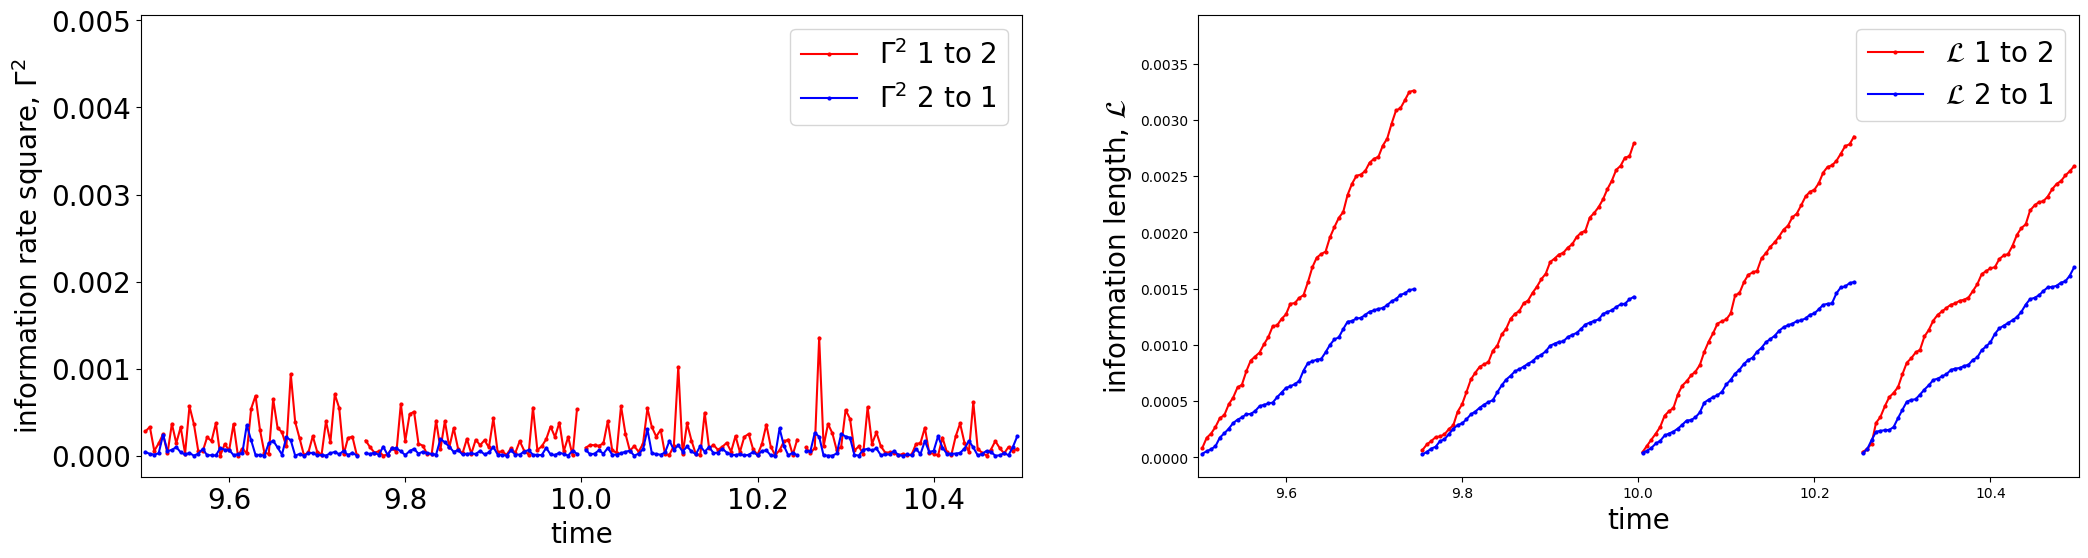

In [ ]:
fig = plt.figure(figsize=(25, 6))
ax1 = fig.add_subplot(1, 2, (1))
ax2 = fig.add_subplot(1, 2, (2))
for i in range(len(datatimecausal_kernel)):
    ax1.plot(datatimecausal_kernel[i], dataratecausal_kernel['rate_1to2'][i], 'ro-', ms=2, label='$\Gamma^2$ 1 to 2')
    ax1.plot(datatimecausal_kernel[i], dataratecausal_kernel['rate_2to1'][i], 'bo-', ms=2, label='$\Gamma^2$ 2 to 1')

    ax2.plot(datatimecausal_kernel[i], lencausal1to2_kernel[i], 'ro-', ms=2, label='$\mathcal{L}$ 1 to 2')
    ax2.plot(datatimecausal_kernel[i], lencausal2to1_kernel[i], 'bo-', ms=2, label='$\mathcal{L}$ 2 to 1')

#ax1.set_yscale('log')
ax1.set_xlim(9.5, 10.5)
#ax1.set_ylim(-0.05, 8.0)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('time', fontsize=20)
ax1.set_ylabel('information rate square, $\Gamma^2$', fontsize=20)

ax2.set_xlim(9.5, 10.5)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('information length, $\mathcal{L}$', fontsize=20)

handles1, labels1 = ax1.get_legend_handles_labels()
display = [0,1]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best', fontsize=20)

handles2, labels2 = ax2.get_legend_handles_labels()
display = [0,1]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best', fontsize=20)

#plt.savefig(f'/content/drive/MyDrive/{name}/causal-info-kernel_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

plt.show()

#plt.savefig(f'/content/drive/MyDrive/{name}/causal-info-kernel_sim{sim}_win{win}-{name}.pdf', bbox_inches='tight')

In [ ]:
'''
#estimate the evolution of the [pdf] at different instance via [kernel density estimation]
win = 100
sld = 10
pnt = 100
datapdf_kernel, datatime_kernel = pdf_evol_kernel(x1, x2, tdata, win, sld, sim, pnt)
'''

In [ ]:
'''
###[save] the [information rate] data###
np.save(f'/content/drive/MyDrive/{name}/info_pdf-kernel-{name}', datapdf_kernel) #[information rate] data
np.save(f'/content/drive/MyDrive/{name}/info_pdf-time-kernel-{name}', datatime_kernel) #[information rate] time
'''